## Idea

We want to model the simple receptive field model using a gated deep linear net (GDLN).
To do this, we need to establish two important points:
1. the gating structure, and
2. that we can use small initial weights (we'll probably need this for working with the ODEs later on).

We will begin with item 1.
To find the gating structure, we need to see that our observations from the model with sigmoid activation does not change if we switch to ReLU.
We will do this in both the nonlinear Gaussian process (NLGP) and single pulse (SP) datasets.
In doing this, we will realize the functional roles of localized and oscillatory neurons.
We will also see that a learnable bias term in the first layer is crucial for the model to learn the task.

We'll address item 2 in a later notebook.

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution


def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def viz_activations(x, weight, bias, act, localized=None):
    if localized is not None:
        n_localized = localized.sum()
        weight = np.concatenate([weight[localized], weight[~localized]])
        bias = np.concatenate([bias[localized], bias[~localized]])

    x = x.reshape(1, -1)
    bias = bias.reshape(-1, 1)    
    preact = weight @ x.T + bias
    postact = act(preact)
    out = postact.mean()
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
    ax1.plot(x.flatten())
    ax1.set_title('Input')
    ax2.plot(preact.flatten(), 'o')
    ax2.set_title('Preactivation')
    ax3.plot(postact.flatten(), 'o')
    ax3.set_title(f'Postactivation, out={out:.2f}')
    
    if localized is not None:
        ax2.axvline(n_localized, color='red')
        ax3.axvline(n_localized, color='red')
        
    return fig, (ax1, ax2, ax3)

## NLGP dataset

Throughout this section, we'll use the settings defined in config_ below.

We'll start with sigmoid activation.
We'll see that we get a pretty nice 50/50 split into localized and oscillatory neurons.
When we switch to ReLU, we'll see that we get either all localized or all oscillatory neurons, which depends on whether the long- or short-range correlation inputs correspond to the negative class label.
($\xi_1$ always has a label of 1, and $\xi_2$ has a label of 0.)

In [22]:
config_ = dict(
  seed=0,
  num_dimensions=40,
  num_hiddens=100, # ORIG: --100-- 400
  init_scale=1.0,
  model_cls=models.SimpleNet,
  use_bias=True,
  optimizer_fn=optax.sgd,
  batch_size=1000,
  dataset_cls=datasets.NonlinearGPDataset,
  support=(-1, 1),
  class_proportion=0.5,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  save_=True,
)

Already simulated


Text(0.5, 0, 'Inputs')

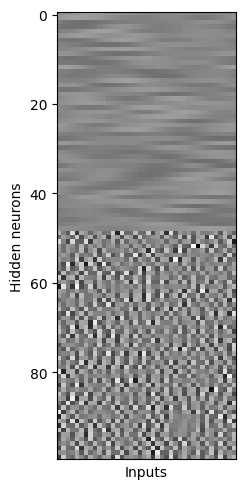

In [26]:
config = config_.copy()
config['xi1'] = 2
config['xi2'] = 1
config['gain'] = 0.01 # 3
config['learning_rate'] = 50 # ORIG: 100
config['num_epochs'] = 5000 # 10000
config['activation'] = 'sigmoid'
config['evaluation_interval'] = 500 # 10
config['init_scale'] = 1 # 5.0
config['seed'] = 1

weights1, metrics1 = simulate_or_load(**config)
# fig, axs = plot_receptive_fields(weights1, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)
fig, axs = plot_receptive_fields(weights1[[-1]], num_cols=11, evaluation_interval=500, figsize=(30, 20), reordering_fn=entropy_sort, center_sort=True, ind=-1)
axs[0].set_xlabel('Inputs')

In [100]:
fig.savefig('rfs_new.png', dpi=300, bbox_inches='tight')

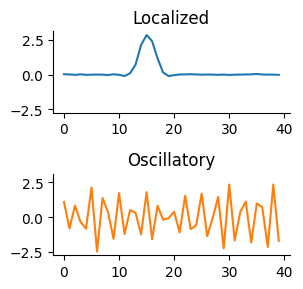

In [149]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 3), sharey=True)
ax1.plot( weights1[-1,22], label='Localized', color='tab:blue' )
ax2.plot( weights1[-1,2], label='Oscillatory', color='tab:orange' )
ax1.set_title('Localized')
ax2.set_title('Oscillatory')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.set_xticks([]); 
    # ax.set_yticks([])
    
fig.tight_layout()

In [150]:
fig.savefig('example_rfs2.png', dpi=300, bbox_inches='tight')

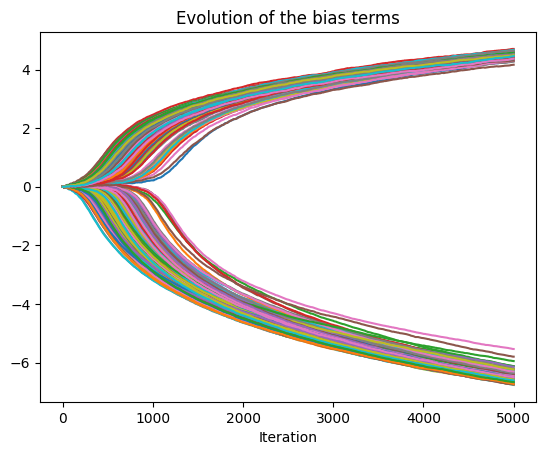

In [102]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])
plt.plot(np.arange(501) * 10, bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

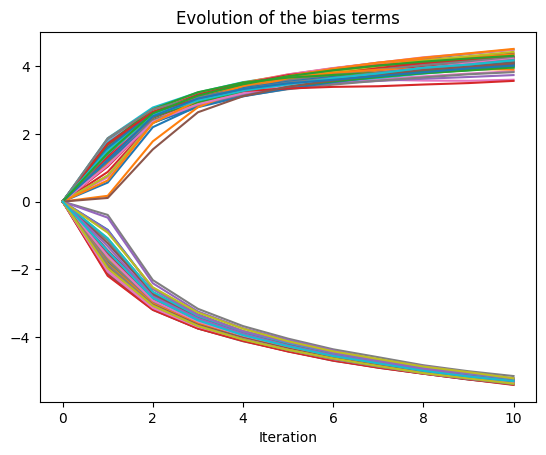

In [27]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])
plt.plot(np.arange(len(bias1)), bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

In [106]:
from localization.utils import build_gaussian_covariance, build_non_gaussian_covariance
# Sigma1 = build_gaussian_covariance(40, 2)
# Sigma0 = build_gaussian_covariance(40, 1)
Sigma1 = build_non_gaussian_covariance(40, 2, 3)
Sigma0 = build_non_gaussian_covariance(40, 1, 3)

sigma11 = np.diag( weights1[0] @ Sigma1 @ weights1[0].T )
tau11 = np.diag( weights1[0] @ Sigma0 @ weights1[0].T )

bias1 = np.stack([ m[3] for m in metrics1 ])
db0 = 1 / np.sqrt( sigma11 + 1 ) - 1 / np.sqrt( tau11 + 1 )

np.mean(np.sign(db0) == np.sign(bias1[-1]))

0.9725

In [109]:
db0.shape

(400,)

## Bias splitting (Gaussian)

In [28]:
from localization.utils import build_gaussian_covariance, build_non_gaussian_covariance
# Sigma1 = build_gaussian_covariance(40, 2)
# Sigma0 = build_gaussian_covariance(40, 1)
Sigma1 = build_non_gaussian_covariance(40, 2, 0.01)
Sigma0 = build_non_gaussian_covariance(40, 1, 0.01)

sigma11 = np.diag( weights1[0] @ Sigma1 @ weights1[0].T )
tau11 = np.diag( weights1[0] @ Sigma0 @ weights1[0].T )

bias1 = np.stack([ m[3] for m in metrics1 ])
db0 = 1 / np.sqrt( sigma11 + 1 ) - 1 / np.sqrt( tau11 + 1 )

np.mean(np.sign(db0) == np.sign(bias1[-1]))

0.95

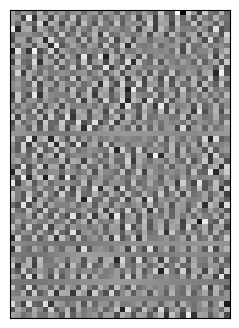

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow( weights1[-1,db0 > 0], cmap='gray' )
ax.set_xticks([]); ax.set_yticks([])
fig.savefig('gauss_bias_rfs_osc.png', dpi=300)

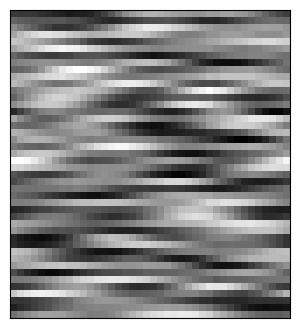

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow( weights1[-1,db0 < 0], cmap='gray' )
ax.set_xticks([]); ax.set_yticks([])
fig.savefig('gauss_bias_rfs_osc.png', dpi=300)

ValueError: x and y must have same first dimension, but have shapes (501,) and (11, 44)

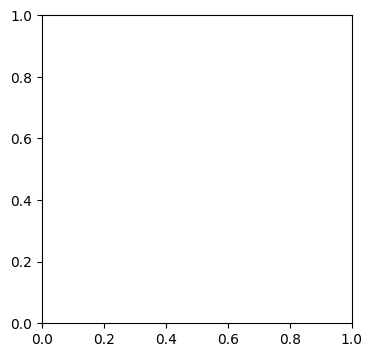

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
its = np.arange(501) * 10
ax.plot(its, bias1[:,db0 <= 0], color='tab:orange', alpha=0.5, label='Eqn 2 < 0')
ax.plot(its, bias1[:,db0 > 0], color='tab:blue', alpha=0.2, label='Eqn 2 > 0')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_ylabel('Bias')
ax.set_xlabel('Iteration')
fig.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig('bias_splitting.png', dpi=300, bbox_inches='tight')

## Bias splitting (NLGP)

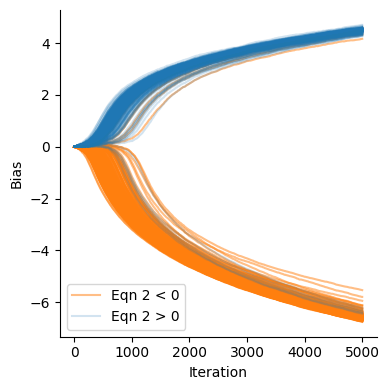

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
its = np.arange(501) * 10
ax.plot(its, bias1[:,db0 <= 0], color='tab:orange', alpha=0.5, label='Eqn 2 < 0')
ax.plot(its, bias1[:,db0 > 0], color='tab:blue', alpha=0.2, label='Eqn 2 > 0')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_ylabel('Bias')
ax.set_xlabel('Iteration')
fig.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('bias_splitting.png', dpi=300, bbox_inches='tight')

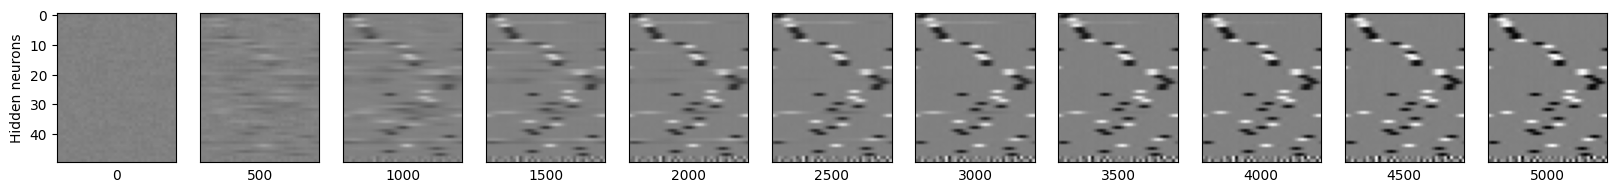

In [132]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# ax.imshow( weights1[-1,db0 <= 0][::5], cmap='gray' )

fig, axs = plot_receptive_fields(weights1[::50,db0 <= 0][:,::4], num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, center_sort=True, ind=-1)
fig.savefig('symm_break_rfs_db0neg.png', dpi=300, bbox_inches='tight')

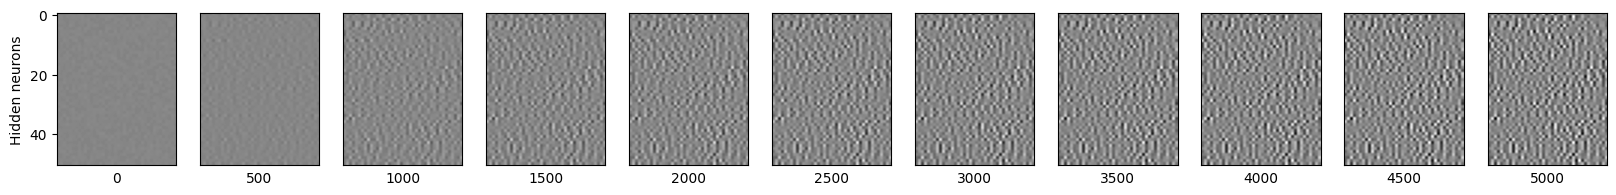

In [133]:
fig, axs = plot_receptive_fields(weights1[::50,db0 > 0][:,::4], num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, center_sort=True, ind=-1)
fig.savefig('symm_break_rfs_db0pos.png', dpi=300, bbox_inches='tight')

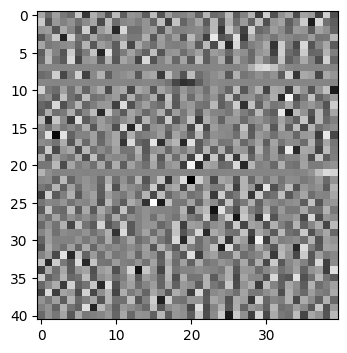

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow( weights1[-1,db0 > 0][::5], cmap='gray' )

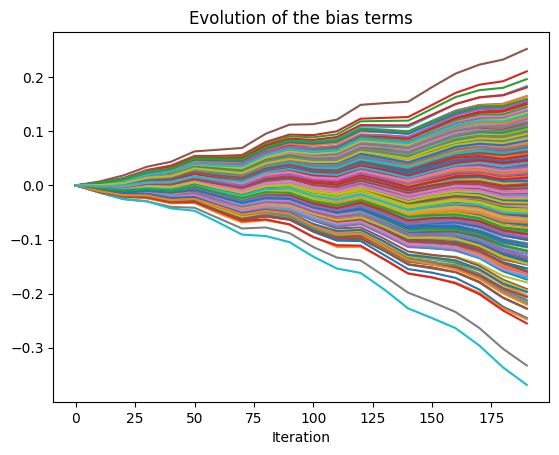

In [44]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])[:20]
plt.plot(np.arange(bias1.shape[0]) * 10, bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

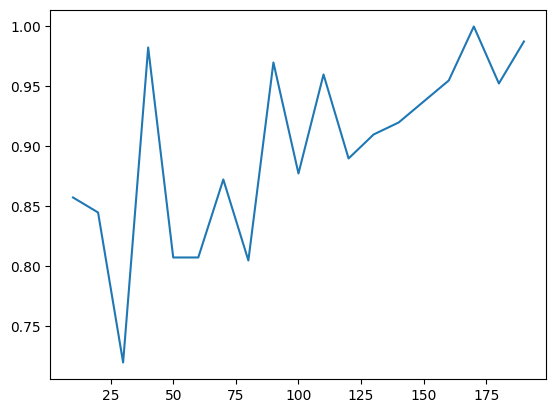

In [45]:
sign1 = bias1 > 0
same1 = sign1[1:] == sign1[:-1]
_ = plt.plot( np.arange(1,bias1.shape[0]) * 10, same1.mean(axis=1) )

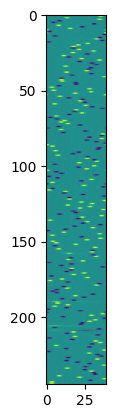

In [32]:
_ = plt.imshow( weights1[-1, bias1[-1] < 0] )

In [46]:
from localization.utils import build_gaussian_covariance, build_non_gaussian_covariance
# Sigma1 = build_gaussian_covariance(40, 2)
# Sigma0 = build_gaussian_covariance(40, 1)
Sigma1 = build_non_gaussian_covariance(40, 2, 3)
Sigma0 = build_non_gaussian_covariance(40, 1, 3)

In [47]:
sigma11 = np.diag( weights1[0] @ Sigma1 @ weights1[0].T )
tau11 = np.diag( weights1[0] @ Sigma0 @ weights1[0].T )

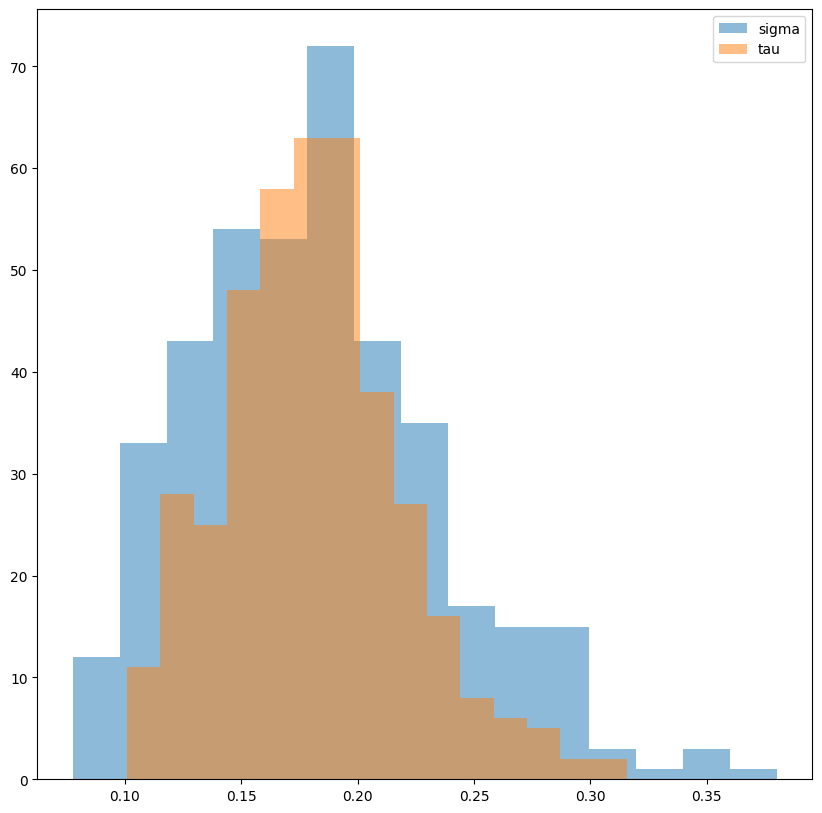

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(sigma11, bins=15, alpha=0.5, label='sigma')
ax.hist(tau11, bins=15, alpha=0.5, label='tau')
ax.legend()

In [49]:
bias1 = np.stack([ m[3] for m in metrics1 ])
db0 = 1 / np.sqrt( sigma11 + 1 ) - 1 / np.sqrt( tau11 + 1 )

In [37]:
sigma11 / (sigma11 + 1)

array([0.92850333, 0.89147127, 0.9160455 , 0.90262026, 0.87743837,
       0.87578773, 0.860675  , 0.9397308 , 0.9350661 , 0.8718873 ,
       0.8504116 , 0.88187194, 0.9181432 , 0.849452  , 0.87328976,
       0.9097597 , 0.8573096 , 0.9000053 , 0.9286404 , 0.885562  ,
       0.9215124 , 0.84787315, 0.9180526 , 0.86834097, 0.88699156,
       0.90966666, 0.91454303, 0.92199767, 0.9026893 , 0.9192624 ,
       0.877521  , 0.8391121 , 0.9165945 , 0.85266036, 0.8947829 ,
       0.89303815, 0.89219356, 0.87746084, 0.85649335, 0.84715074,
       0.9026619 , 0.9343771 , 0.909913  , 0.8811313 , 0.86217296,
       0.9311532 , 0.91571414, 0.9141185 , 0.85427284, 0.87715584,
       0.915563  , 0.9205509 , 0.8379067 , 0.83624446, 0.92094314,
       0.8452209 , 0.9271582 , 0.8893737 , 0.90577596, 0.9181142 ,
       0.9111294 , 0.8050043 , 0.81375265, 0.87889004, 0.89708453,
       0.89758533, 0.8571113 , 0.8965047 , 0.9359135 , 0.90646404,
       0.85557556, 0.8755318 , 0.91455185, 0.86578274, 0.89231

In [12]:
db0[np.sign(db0) != np.sign(bias1[-1])]

array([0.01070088, 0.00670516, 0.0111689 , 0.00382417, 0.00379437,
       0.00032982, 0.00969893, 0.00944   , 0.00529823, 0.00296566,
       0.00812578, 0.0016951 , 0.01096407], dtype=float32)

In [13]:
bias1[3][np.sign(db0) != np.sign(bias1[-1])]

array([ 0.00012124, -0.01965776, -0.0092002 , -0.03144416, -0.00153538,
       -0.04459485,  0.01289647,  0.0081344 , -0.01641442, -0.02298802,
        0.00871903, -0.03619132,  0.00538076], dtype=float32)

In [14]:
db0[np.sign(db0) == np.sign(bias1[-1])]

array([-0.03938225,  0.03106099,  0.01669356,  0.01871002,  0.0296059 ,
        0.04050177, -0.01790112,  0.00976786,  0.04064649, -0.01337597,
       -0.01202989,  0.01849902,  0.04040673,  0.01104325, -0.00674638,
        0.02616107,  0.01928148,  0.02869514, -0.0292156 , -0.03153211,
       -0.01912755,  0.02127072,  0.02466092, -0.01166746, -0.01900309,
        0.01620239, -0.0060268 ,  0.03603977,  0.05952549,  0.04888725,
        0.09066617,  0.05348259, -0.01629809, -0.0482454 , -0.00673181,
        0.03983361, -0.02494365, -0.01067778,  0.01577041,  0.02448106,
        0.06096619,  0.0277248 , -0.01506361, -0.02302986, -0.01603287,
        0.05818713, -0.03035355,  0.05761817, -0.01203406, -0.01404545,
       -0.00740072, -0.0180324 ,  0.01254255, -0.05626032, -0.00916457,
       -0.00881788,  0.02148333,  0.01647931, -0.01232228,  0.01575539,
       -0.01762757,  0.05995533,  0.03066173, -0.00494903,  0.02640206,
        0.0232088 , -0.00431684, -0.01362818,  0.02856809, -0.00

In [15]:
np.exp( -0.5 / np.sqrt( tau11 + 1 ) * bias1[1] )

array([1.0156897 , 0.99517906, 0.9986436 , 0.9967241 , 1.0029368 ,
       0.9948001 , 1.0040506 , 1.0014766 , 0.9906334 , 1.0081152 ,
       0.99893206, 0.99335515, 1.0087515 , 1.0051941 , 1.0078428 ,
       1.000228  , 0.9884043 , 1.0004784 , 1.0007541 , 1.0037187 ,
       0.99845654, 0.9998584 , 1.0058006 , 0.99565226, 1.0165002 ,
       1.0146226 , 1.005356  , 1.0006542 , 1.0008329 , 1.0069653 ,
       1.0087296 , 0.9992419 , 1.0081375 , 0.9958678 , 0.98747545,
       0.9914579 , 0.97594273, 0.98908806, 1.0078237 , 1.0179856 ,
       1.0070591 , 0.99325454, 1.0149565 , 1.0080596 , 1.0001216 ,
       0.99714905, 0.98968565, 0.9982615 , 1.0055012 , 1.0134728 ,
       1.0030174 , 1.0122898 , 1.001127  , 0.9892121 , 1.0114748 ,
       0.99010146, 1.0101092 , 1.0123236 , 1.0087304 , 1.0075767 ,
       1.0006564 , 1.002926  , 1.0230687 , 1.0063856 , 1.006987  ,
       1.0010062 , 0.9967784 , 1.0070711 , 1.0007415 , 1.010955  ,
       1.0041673 , 0.98633146, 0.9930128 , 1.005254  , 1.00010

In [50]:
np.mean(np.sign(bias1[1]) == np.sign(db0))

0.635

In [51]:
np.mean(np.sign(bias1[1]) == np.sign(bias1[-1]))

0.6325

In [105]:
np.mean(np.sign(db0) == np.sign(bias1[-1]))

0.9725

In [27]:
print( np.linalg.eigh(Sigma1)[0].sum() )
print( np.linalg.eigh(Sigma0)[0].sum() )
print( (np.linalg.eigh(Sigma1)[0] ** 2).sum() )
print( (np.linalg.eigh(Sigma0)[0] ** 2).sum() )

40.0
40.0
82.61896
46.55715


In [63]:
t = 1
np.diag(weights1[t] @ Sigma1 @ weights1[t].T) #/ np.diag(weights1[t] @ Sigma0 @ weights1[t].T)

array([0.5249736 , 0.34885874, 0.5016591 , 0.57097673, 0.59913486,
       0.7031601 , 0.64905506, 0.56768745, 0.50226074, 0.8296519 ,
       0.44215944, 0.8910183 , 0.62337196, 0.5219296 , 0.6164046 ,
       0.8214361 , 0.6280254 , 0.63290083, 0.60328174, 0.4851986 ,
       0.7938738 , 0.7108271 , 0.6568859 , 0.6498634 , 0.39822644,
       0.8901711 , 0.3098847 , 0.40159437, 0.38444442, 0.6310257 ,
       0.45293438, 0.69753647, 0.73652065, 0.6506935 , 0.6221167 ,
       0.8887467 , 0.3060565 , 0.4379665 , 0.77267915, 0.6664383 ,
       0.74302745, 0.5743306 , 0.45483312, 0.7333157 , 0.5269556 ,
       0.59597486, 0.4489075 , 0.58562803, 0.3847934 , 0.4642778 ,
       0.43306044, 0.51283264, 0.40971196, 0.5006164 , 0.7946571 ,
       0.66980296, 0.44977602, 0.84374946, 0.5171821 , 0.3390555 ,
       0.33099216, 0.3972647 , 0.5253701 , 0.45775107, 0.4451917 ,
       0.5231758 , 0.62759566, 0.44160485, 0.6940326 , 0.8765957 ,
       0.3625227 , 0.58533764, 0.7707823 , 0.5865337 , 0.80185

In [20]:
norms = np.square(weights1).sum(axis=2)
weighted_norms1 = np.sum((weights1.reshape(-1, 40) @ Sigma1) * weights1.reshape(-1, 40), axis=1).reshape(-1, 100)
weighted_norms0 = np.sum((weights1.reshape(-1, 40) @ Sigma0) * weights1.reshape(-1, 40), axis=1).reshape(-1, 100)

Text(0.5, 1.0, 'Norms with Sigma0')

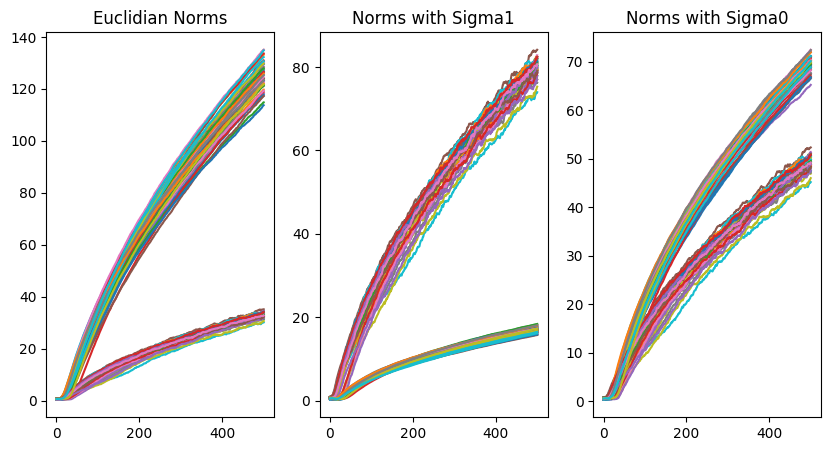

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].plot(norms)
axs[0].set_title('Euclidian Norms')
axs[1].plot(weighted_norms1)#[:20])
axs[1].set_title('Norms with Sigma1')
axs[2].plot(weighted_norms0)#[:20])
axs[2].set_title('Norms with Sigma0')

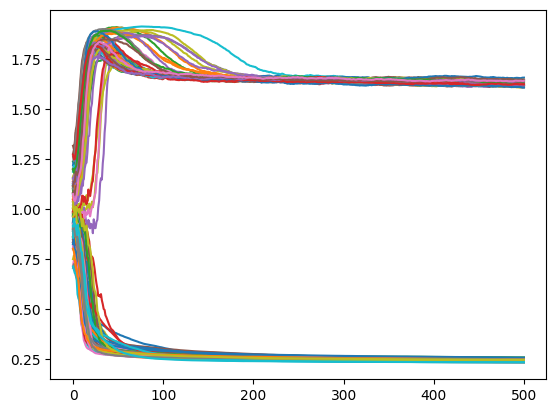

In [23]:
_ = plt.plot( weighted_norms1 / weighted_norms0 )

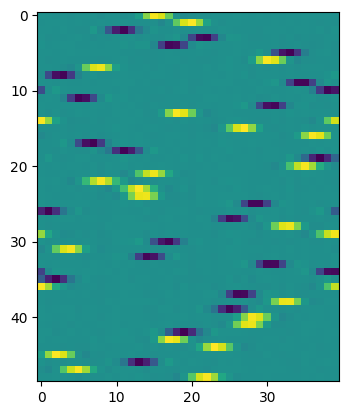

In [40]:
_ = plt.imshow( weights1[-1][weighted_norms1[-1] > 10] )

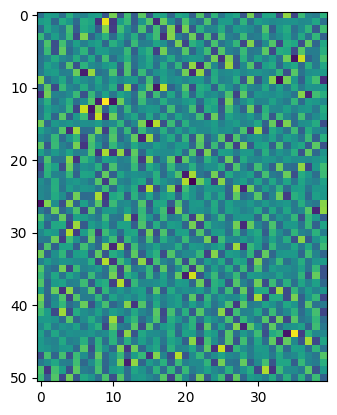

In [41]:
_ = plt.imshow( weights1[-1][weighted_norms1[-1] < 10] )

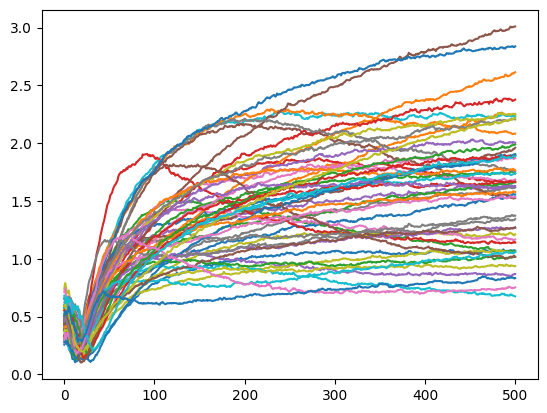

In [43]:
_ = plt.plot( weighted_norms1[:,weighted_norms1[-1] < 10] )

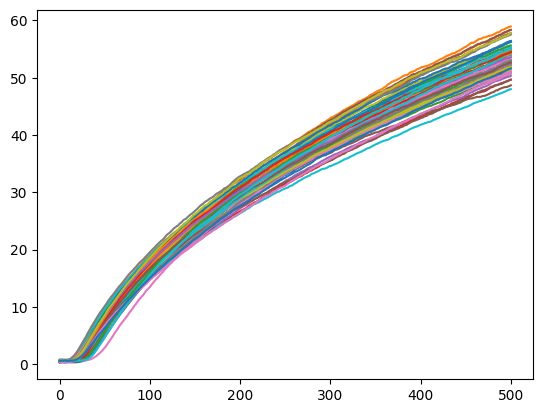

In [47]:
_ = plt.plot( weighted_norms0[:,weighted_norms1[-1] < 10] )

/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


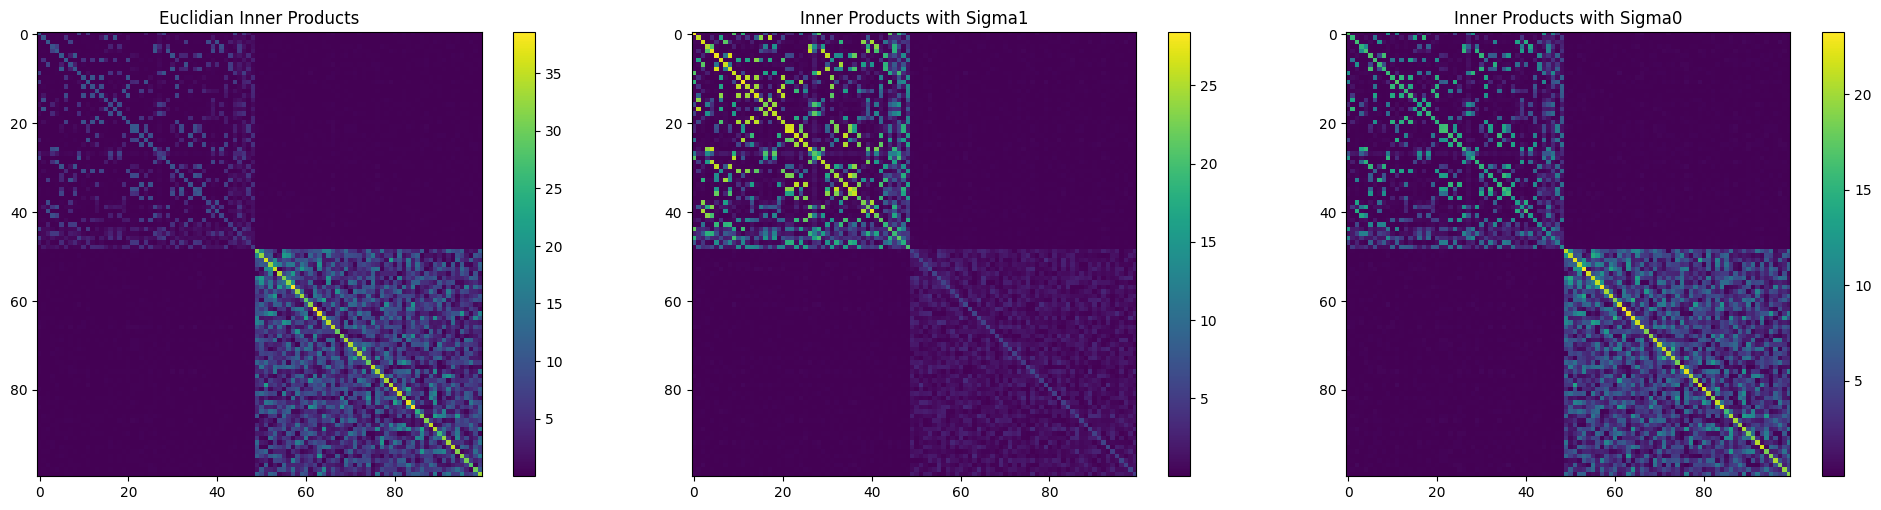

In [24]:
# look at last timestep weighted inner product
t = 100 # 200
order_ = np.argsort(weighted_norms1[-1])[::-1]
weights1_ = weights1[t,order_]
inner = np.abs( weights1_ @ weights1_.T )
weighted_inner1 = np.abs( weights1_ @ Sigma1 @ weights1_.T )
weighted_inner0 = np.abs( weights1_ @ Sigma0 @ weights1_.T )

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
im = axs[0].imshow(inner)
plt.colorbar(im, ax=axs[0])
axs[0].set_title('Euclidian Inner Products')
im = axs[1].imshow(weighted_inner1)
plt.colorbar(im, ax=axs[1])
axs[1].set_title('Inner Products with Sigma1')
im = axs[2].imshow(weighted_inner0)
plt.colorbar(im, ax=axs[2])
axs[2].set_title('Inner Products with Sigma0')
fig.tight_layout()

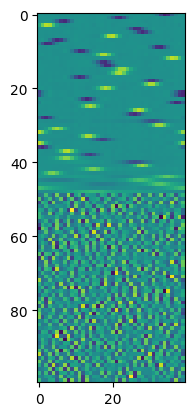

In [91]:
_ = plt.imshow( weights1_ )

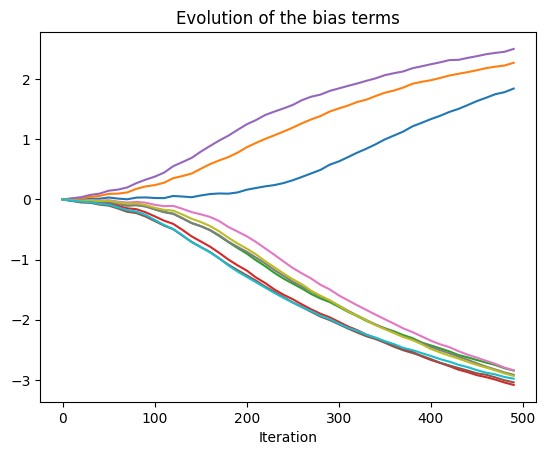

In [14]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])
plt.plot(np.arange(50) * 10, bias1[:50,:10])
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

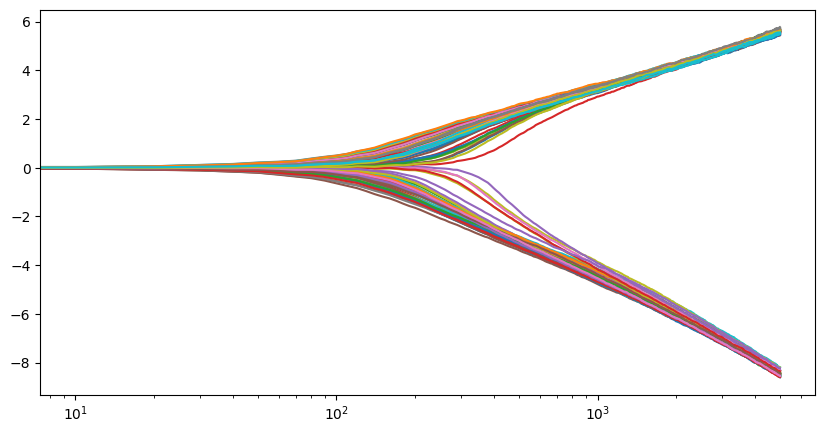

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(501) * 10, bias1)
ax.set_xscale('log')

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'sigmoid',
 'batch_size': 1000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'evaluation_interval': 10,
 'gain': 3,
 'init_fn': <function xavier_normal_init at 0x15af6f880>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 2,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 5000,
 'num_hiddens': 2,
 'optimizer_fn': <function sgd at 0x157ce98a0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': True,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 5000000
Length of eval dataset: 1000
Length of train sampler: 5000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[2,40],
    bias=f32[2],
    in_features=40,
    out_features=2,
    use_bias=True
  ),
  act=<wrapped function 

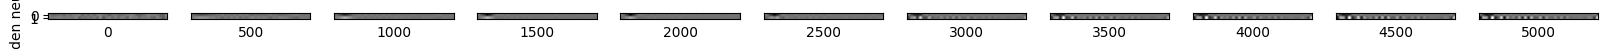

In [13]:
config = config_.copy()
config['xi1'] = 2
config['xi2'] = 1
config['gain'] = 3
config['learning_rate'] = 2 # 100
config['num_epochs'] = 5000
config['activation'] = 'sigmoid'
config['evaluation_interval'] = 10
config['num_hiddens'] = 2
# def positive_biased_init(weight, key, scale):
#     return models.xavier_normal_init(weight, key, scale) + scale
# def negative_biased_init(weight, key, scale):
#     return models.xavier_normal_init(weight, key, scale) - scale
# config['init_fn'] = positive_biased_init
# config['init_fn'] = negative_biased_init

weights1, metrics1 = simulate_or_load(**config)
# fig, axs = plot_receptive_fields(weights1, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)
fig, axs = plot_receptive_fields(weights1[::50], num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

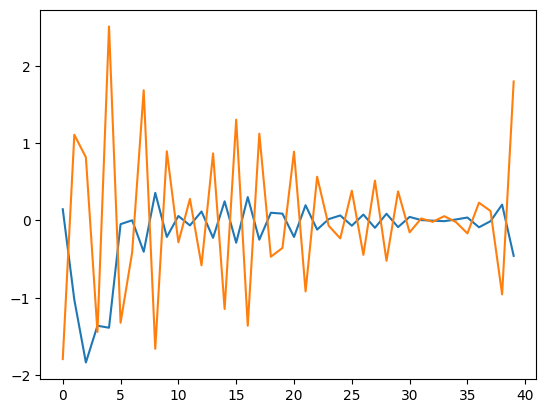

In [16]:
_ = plt.plot( weights1[-1].T )

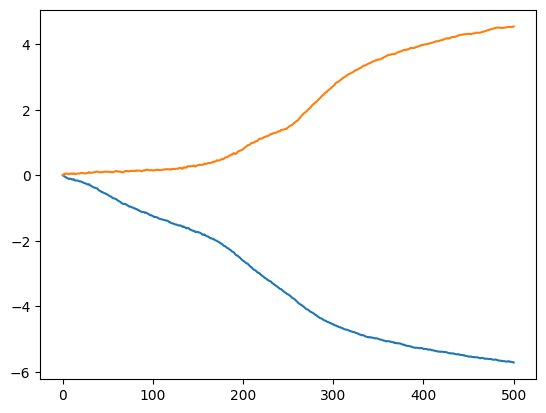

In [18]:
bias1 = np.stack([ m[3] for m in metrics1 ])
_ = plt.plot( bias1 )

In [21]:
bias1[:10]

array([[ 0.        ,  0.        ],
       [-0.01610566,  0.03011129],
       [-0.0424565 ,  0.0384728 ],
       [-0.05280031,  0.05442153],
       [-0.0786467 ,  0.04437768],
       [-0.08162708,  0.05121877],
       [-0.1043419 ,  0.03443188],
       [-0.11363941,  0.03254166],
       [-0.10676588,  0.04825092],
       [-0.10778806,  0.05344101]], dtype=float32)

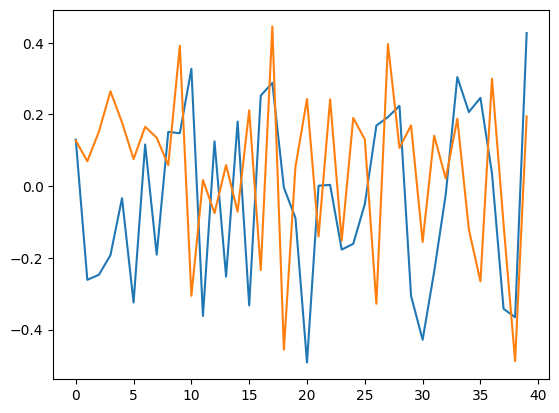

In [24]:
_ = plt.plot( weights1[0].T )

In [26]:
from localization.utils import build_gaussian_covariance
Sigma1 = build_gaussian_covariance(40, 2)
Sigma0 = build_gaussian_covariance(40, 1)

In [33]:
np.linalg.eigh(Sigma1)[0].sum()

40.0

In [35]:
(np.linalg.eigh(Sigma1)[0] ** 2).sum()

100.26512

In [34]:
np.linalg.eigh(Sigma0)[0].sum()

40.0

In [36]:
(np.linalg.eigh(Sigma0)[0] ** 2).sum()

50.85366

In [28]:
# Sigma1
print( weights1[0] @ Sigma1 @ weights1[0].T ) # first neuron (blue) is the localized one
# Sigma0
print( weights1[0] @ Sigma0 @ weights1[0].T )

[[ 2.3710282  -0.41793725]
 [-0.4179373   1.1475488 ]]
[[ 2.5284667  -0.02908255]
 [-0.02908262  1.5117081 ]]


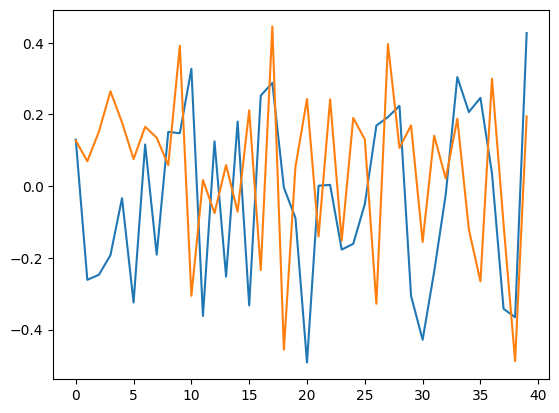

In [30]:
# Sigma1
print( weights1[-1] @ Sigma1 @ weights1[-1].T )
# Sigma0
print( weights1[-1] @ Sigma0 @ weights1[-1].T )

[[21.566975  -4.540482 ]
 [-4.5404806  1.356392 ]]
[[13.427581  -5.911835 ]
 [-5.9118347 16.21929  ]]


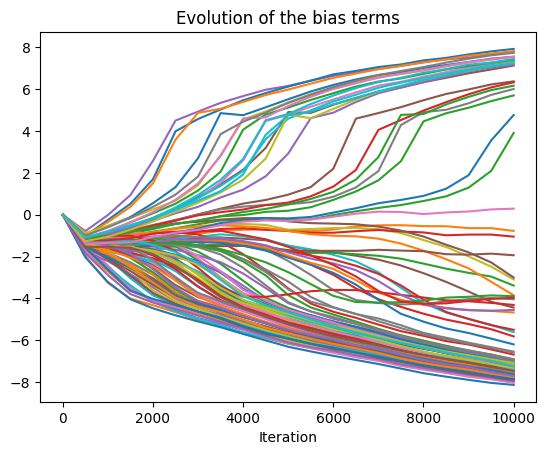

In [84]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])
plt.plot(np.arange(21) * 500, bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

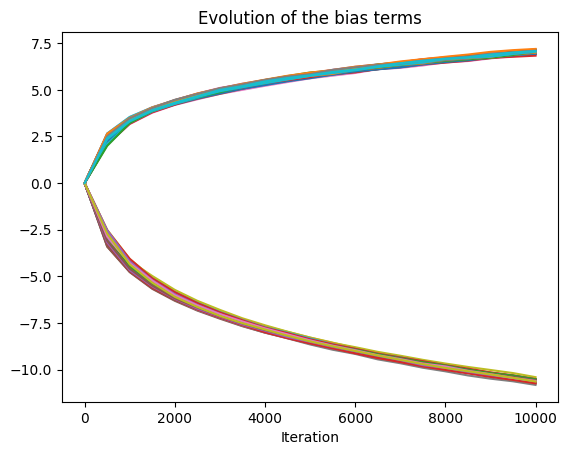

In [111]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])
plt.plot(np.arange(21) * 500, bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

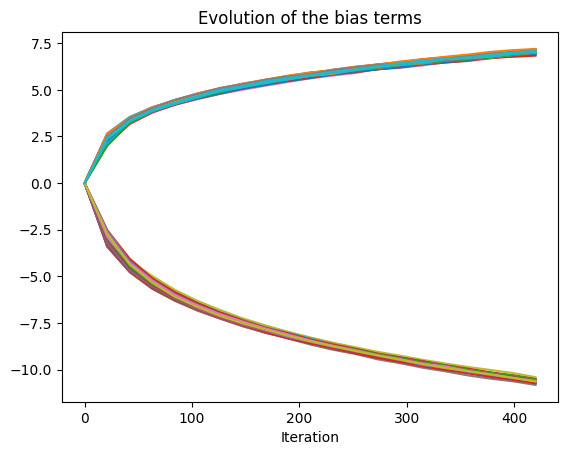

In [113]:
# visualize the evolution of the bias terms
bias1 = np.stack([ m[3] for m in metrics1 ])[:50]
plt.plot(np.arange(21) * bias1.shape[0], bias1)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

Already simulated


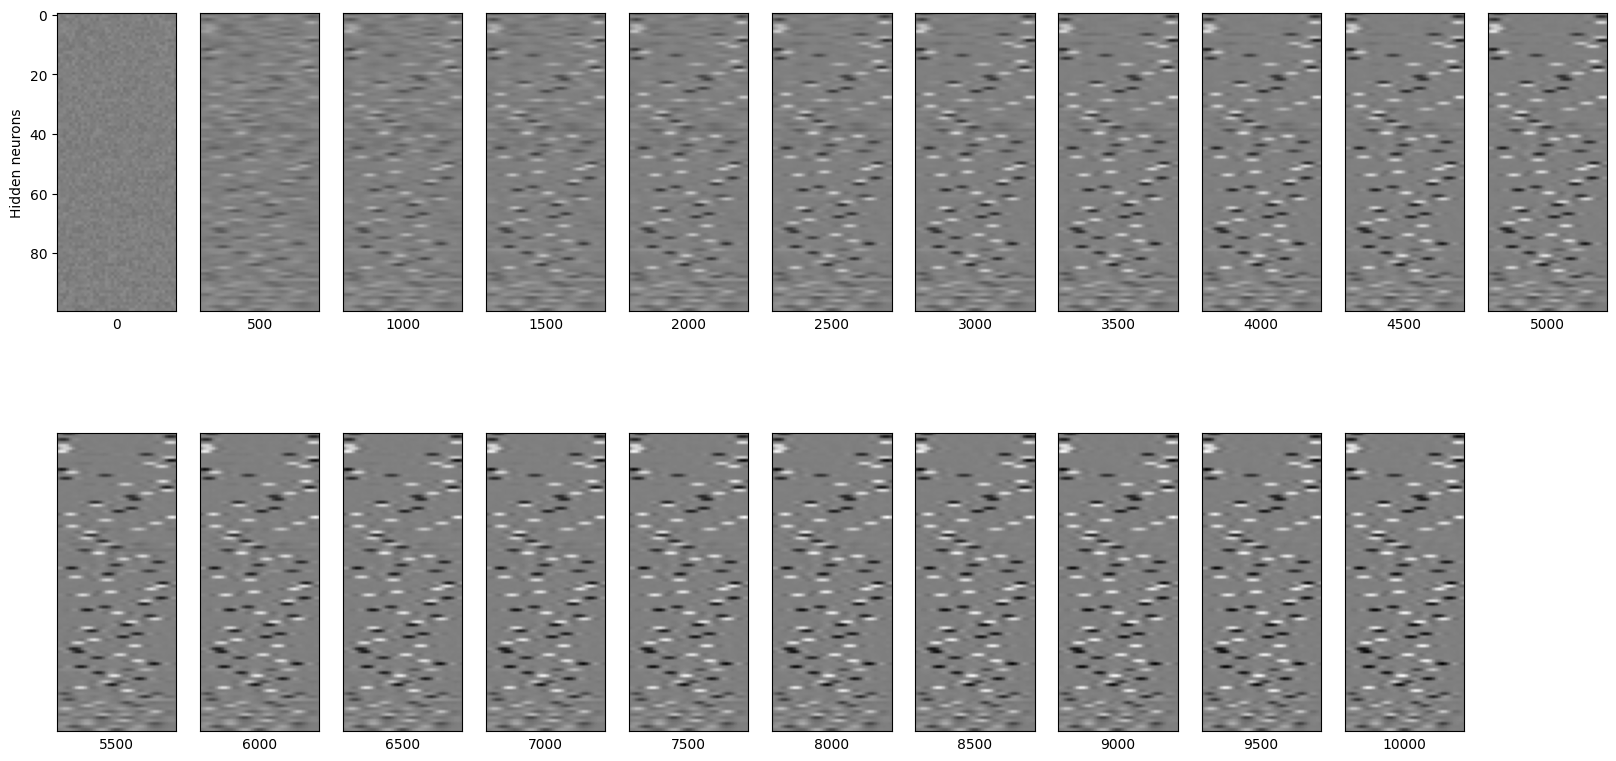

In [48]:
config = config_.copy()
config['xi1'] = 2
config['xi2'] = 1
config['gain'] = 3
config['learning_rate'] = 10.0
config['num_epochs'] = 10000
config['activation'] = 'relu'

weights2, metrics2 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights2, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

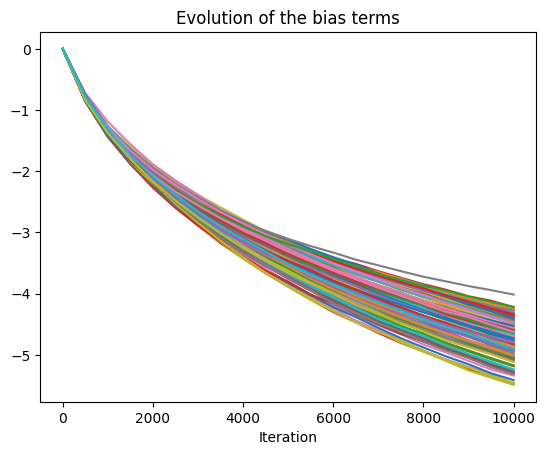

In [49]:
# visualize the evolution of the bias terms
bias2 = np.stack([ m[3] for m in metrics2 ])
plt.plot(np.arange(21) * 500, bias2)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

Already simulated


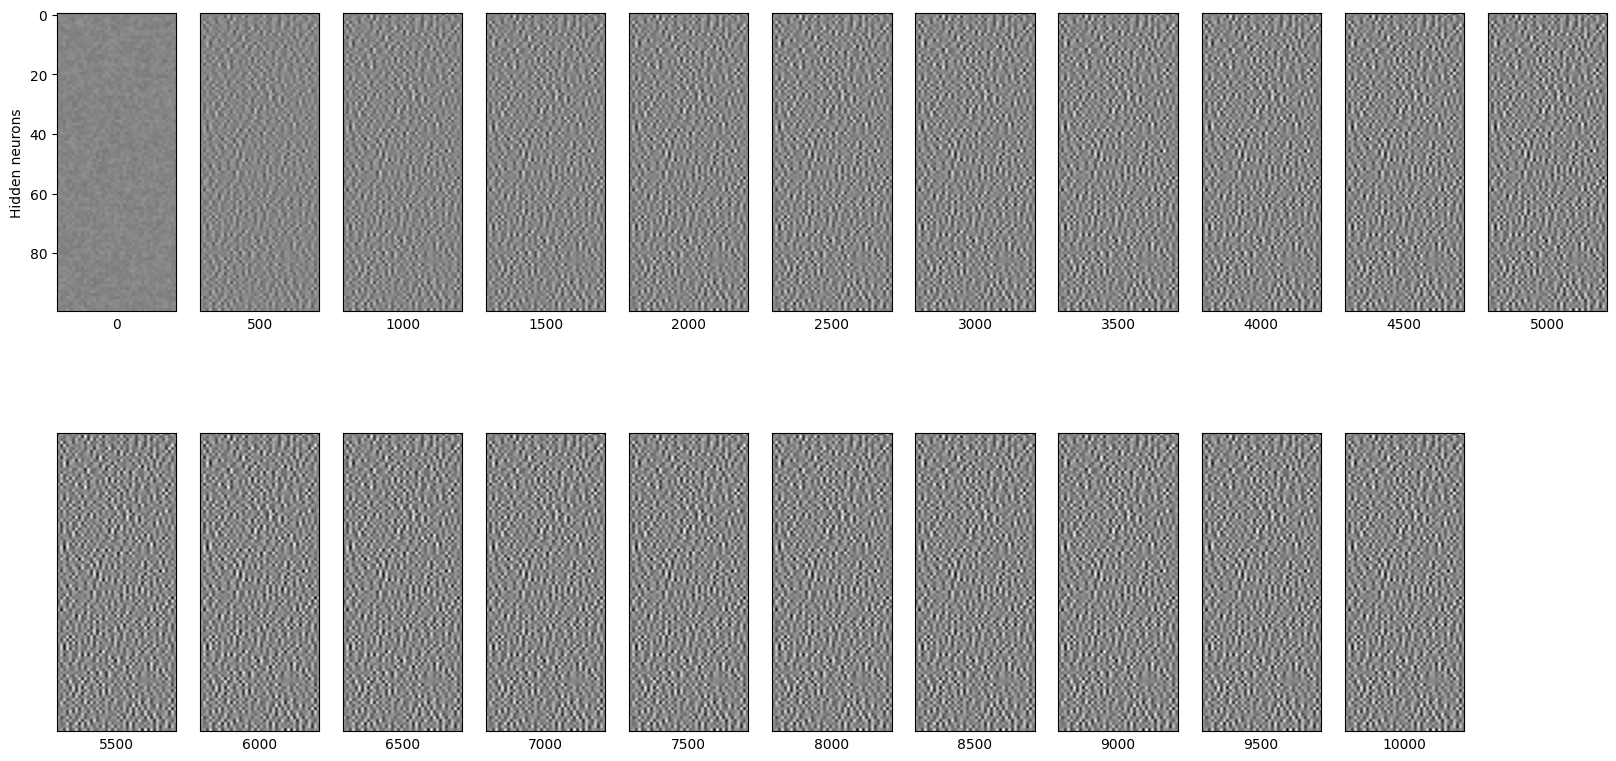

In [50]:
config = config_.copy()
config['xi1'] = 1
config['xi2'] = 2
config['gain'] = 3
config['learning_rate'] = 10.0
config['num_epochs'] = 10000
config['activation'] = 'relu'

weights3, metrics3 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights3, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

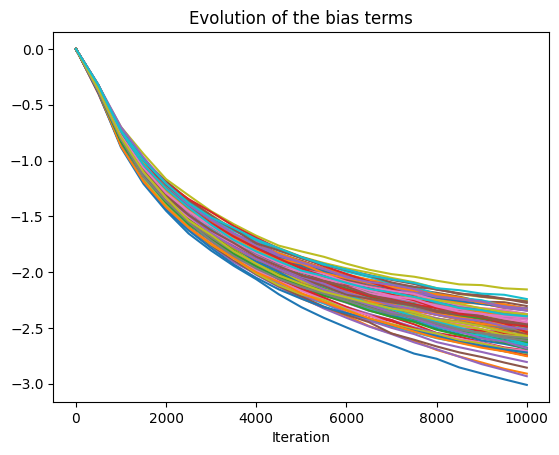

In [51]:
# visualize the evolution of the bias terms
bias3 = np.stack([ m[3] for m in metrics3 ])
plt.plot(np.arange(21) * 500, bias3)
plt.xlabel('Iteration')
plt.title('Evolution of the bias terms')
plt.show()

#### How do we explain this?

The fact that we get either all localized or all oscillatory neurons with ReLU activations gives us insight into the functional roles of these neurons.
To make this more precise, we'll analyze the preactivations of the neurons below.

The preactivations of localized neurons become are slightly heavier at the tails for long-range input than short-range input.
Because their preactivations are mostly very negative and only positive for a few neurons, this overall has the effect of leading to more positive postactivations for the localized neurons.
Note that this construction ensures that the output is (mostly) invariant to a sign flip of the input.
Note that the bias terms allows the preactivations to be generally negative, but their distribution still invariant to a sign flip.
(We will show below that the bias term is necessary for sigmoid activation, but not ReLU activation.)
So, the localized neurons act to bias the output upward slightly in the presence of inputs with long-range correlations, as compared to those with short-range correlations.

The preactivations of oscillatory neurons behave oppositely: the variance of their preactivations shrinks in the presence of long-range input.
Because these preactivations are generally positive, their postactivations become slightly _less positive_.
So the oscillatory neurons bias the output downward slightly in the presence of inputs with long-range correlations, as compared to those with short-range correlations.

The key phenomenon is that __the variance of preactivations changes in opposite directions__ for the two neuron types.
The fact that the localized neurons have generally negative preactivations, and that the oscillatory neurons have generally positive preactivations, is just because $y=1$ corresponds to a long-range signal.
I suspect that if we flipped it (as we do below for ReLU), we would see the localized neurons have generally positive preactivations, and that the oscillatory neurons have generally negative preactivations (though I have not confirmed this yet!).

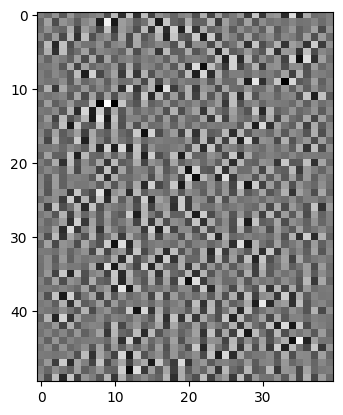

In [52]:
weights1_, bias1_ = weights1[-1], bias1[-1]
weights2_, bias2_ = weights2[-1], bias2[-1]
weights3_, bias3_ = weights3[-1], bias3[-1]

dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), xi1=2, xi2=1, gain=3, support=(-1,1), num_dimensions=40)
x, y = dataset[:100]

localized1 = ipr(weights1_) > 0.15
plt.imshow(weights1_[~localized1], cmap='gray')

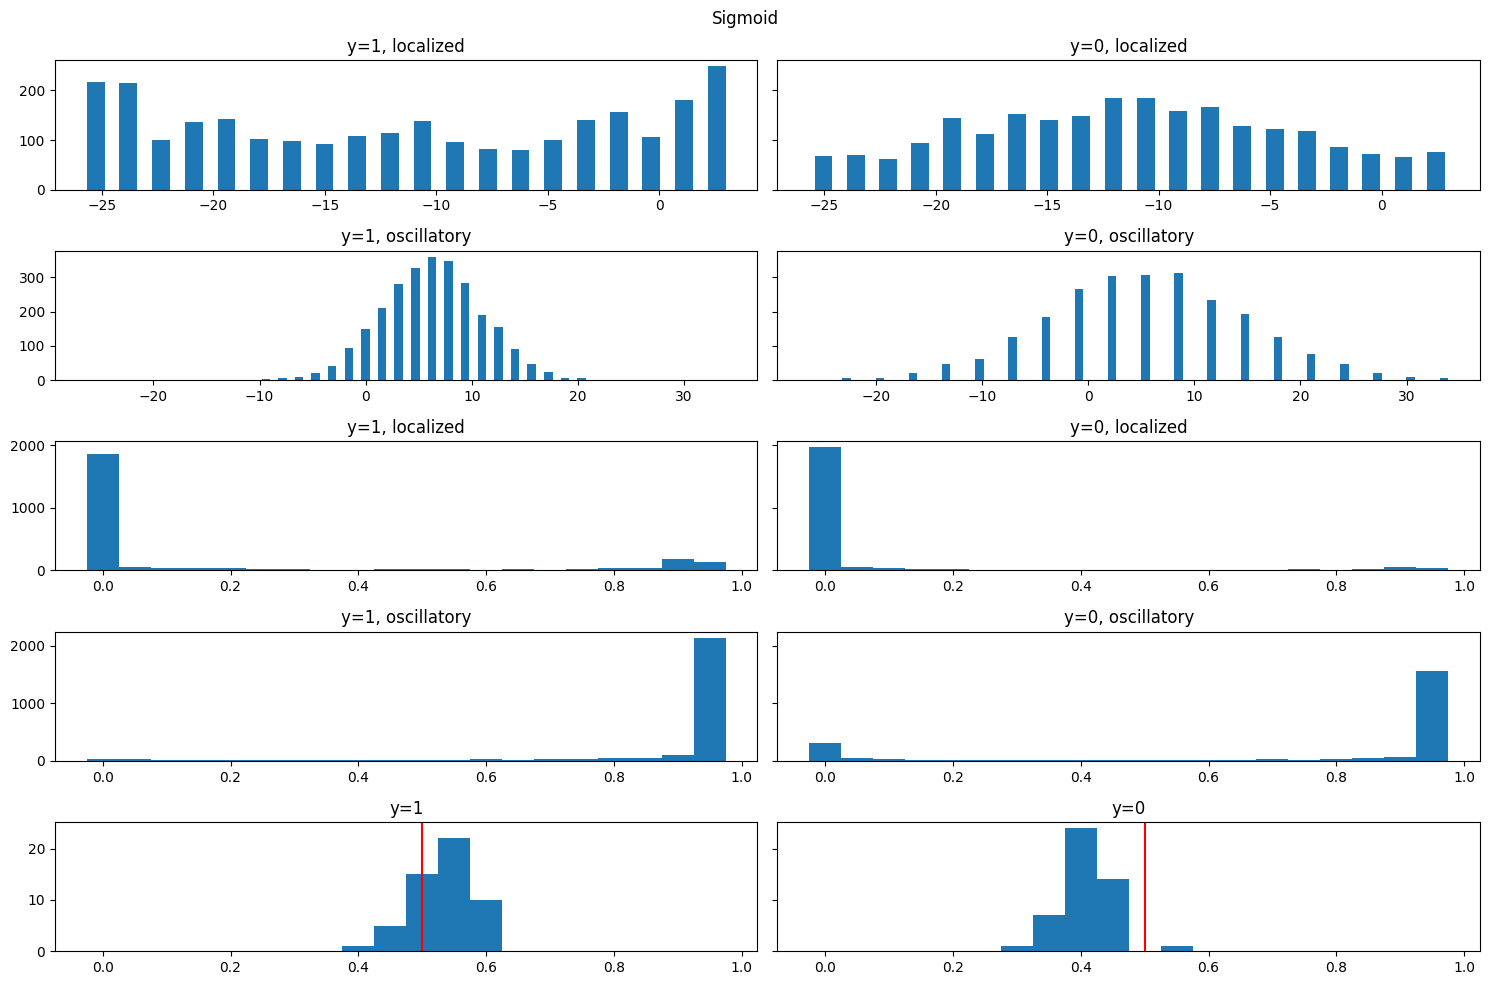

In [53]:
preact1 = weights1_ @ x.T + bias1_.reshape(-1, 1)
postact1 = jax.nn.sigmoid(preact1)
out1 = postact1.mean(axis=0)
fig, axs = plt.subplots(5, 2, figsize=(15, 10), sharex='row', sharey='row')
for row, neuron_mask in enumerate([localized1, ~localized1]):
    for col, ylabel in enumerate([1, 0]):
        # preactivations
        data = preact1[neuron_mask,:][:,y == ylabel].flatten()
        counts, bins = np.histogram(data, bins=20) # , range=(0, 1)
        axs[row, col].bar(bins[:-1], counts)
        axs[row, col].set_title(f'y={ylabel}, {"localized" if row == 0 else "oscillatory"}')
        # postactivations
        data = postact1[neuron_mask,:][:,y == ylabel].flatten()
        counts, bins = np.histogram(data, range=(0, 1), bins=20)
        axs[row+2, col].bar(bins[:-1], counts, width=0.05)
        axs[row+2, col].set_title(f'y={ylabel}, {"localized" if row == 0 else "oscillatory"}')
    # axs[row, 0].set_ylabel('preactivations')
    # axs[row+2, 0].set_ylabel('postactivations')
counts, bins = np.histogram(out1[y == 1], range=(0, 1), bins=20)
axs[4, 0].bar(bins[:-1], counts, width=0.05)
axs[4, 0].set_title('y=1')
axs[4, 0].axvline(0.5, color='red')
counts, bins = np.histogram(out1[y == 0], range=(0, 1), bins=20)
axs[4, 1].bar(bins[:-1], counts, width=0.05)
axs[4, 1].set_title('y=0')
axs[4, 1].axvline(0.5, color='red')
fig.suptitle('Sigmoid')
fig.tight_layout()

Text(0.5, 0.98, 'Bias terms for sigmoid')

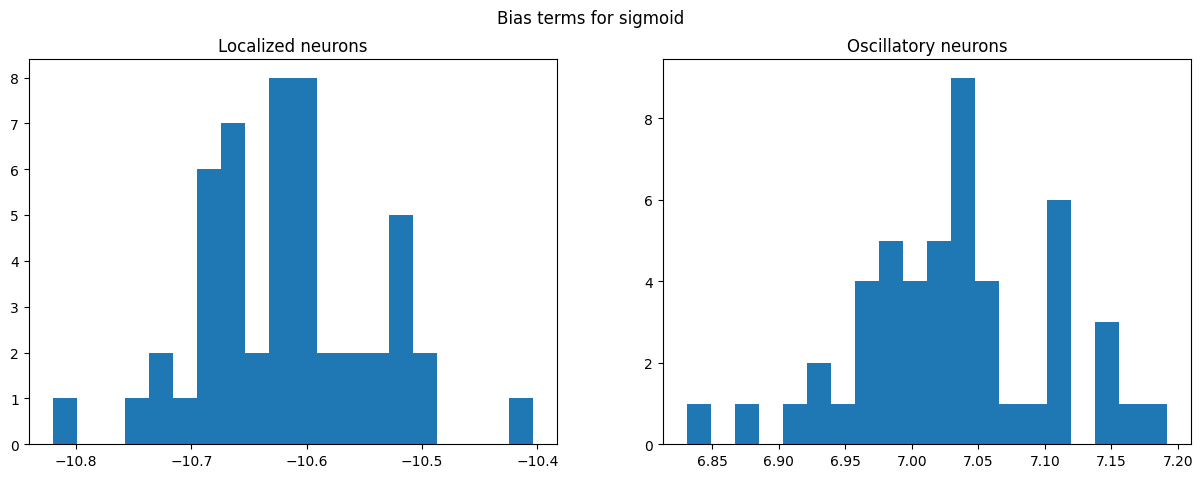

In [54]:
# distribution of bias terms for localized and oscillatory neurons
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(bias1_[localized1], bins=20)
axs[0].set_title('Localized neurons')
axs[1].hist(bias1_[~localized1], bins=20)
axs[1].set_title('Oscillatory neurons')
fig.suptitle('Bias terms for sigmoid')

In the plots below, we show the pre- and postactivations for the localized neurons to the left of the red line, and the oscillatory neurons to the right.

Note that when $y = 1$, the activations of localized neurons are slightly more positive than when $y = 0$.
The opposite is true for oscillatory neurons.

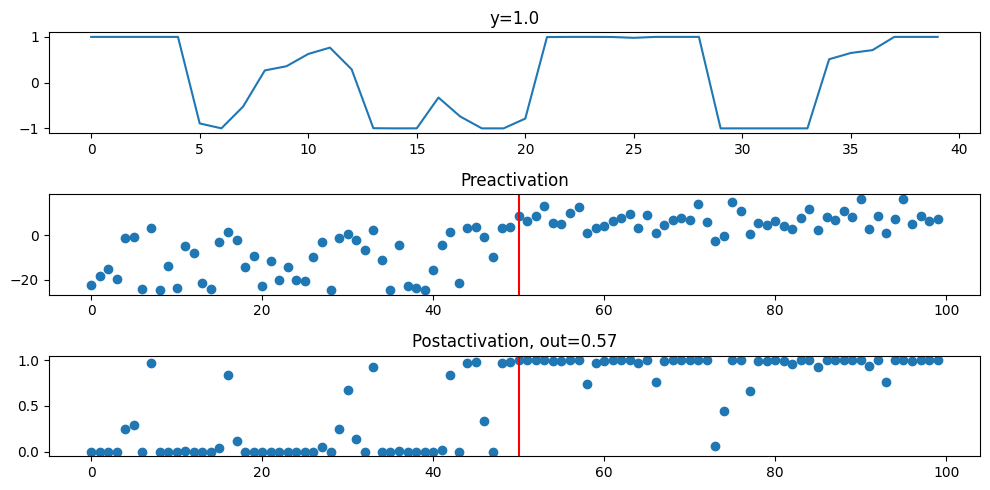

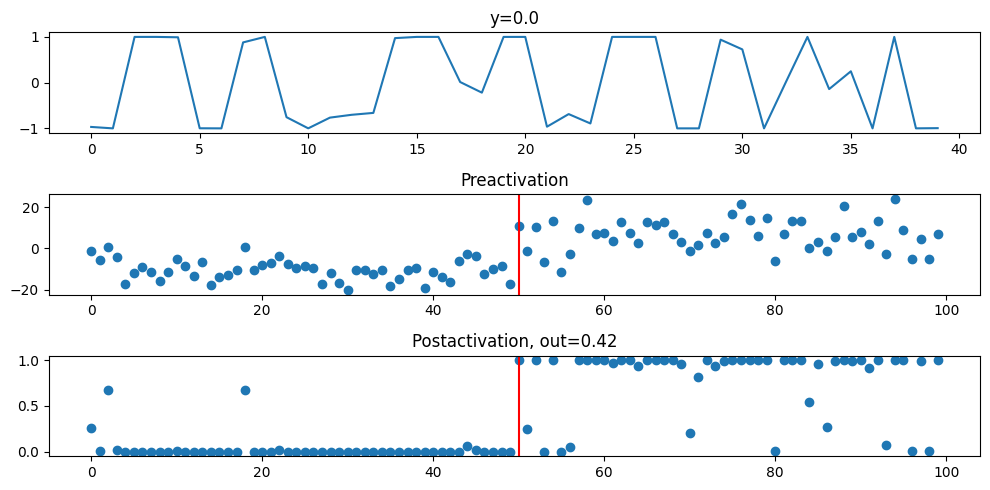

In [55]:
for i in [3, 4]:
    fig, axs = viz_activations(x[i], weights1_, bias1_, jax.nn.sigmoid, localized=localized1)
    axs[0].set_title(f"y={y[i]}")
    fig.tight_layout()

#### And now, ReLU

The key takeaway is that we only seem to be able to get one at a time with ReLU.
So, we probably could not explain symmetry breaking.
(Alessandro claims to get three classes of neurons for 2-D input, but I could not reproduce this exactly.)
But, we still seem to get the same dependence of the shape of localized receptive fields on $g$ (and possibly $\xi_1$ and $\xi_2$ as well, though I have not actually confirmed this).

#### y = 1 corresponds to longer-scale correlation

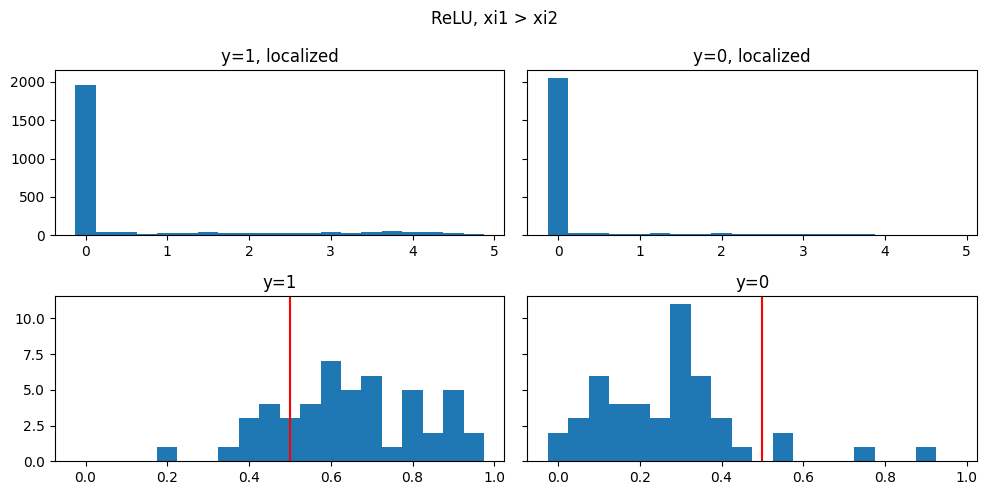

In [226]:
preact2 = weights2_ @ x.T + bias2_.reshape(-1, 1)
postact2 = jax.nn.relu(preact2)
out2 = postact2.mean(axis=0)
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='row', sharey='row')
for col, ylabel in enumerate([1, 0]):
    data = postact2[neuron_mask,:][:,y == ylabel].flatten()
    counts, bins = np.histogram(data, range=(0, 5), bins=20)
    axs[0, col].bar(bins[:-1], counts, width=0.25)
    axs[0, col].set_title(f'y={ylabel}, localized')
counts, bins = np.histogram(out2[y == 1], range=(0, 1), bins=20)
axs[1, 0].bar(bins[:-1], counts, width=0.05)
axs[1, 0].set_title('y=1')
axs[1, 0].axvline(0.5, color='red')
counts, bins = np.histogram(out2[y == 0], range=(0, 1), bins=20)
axs[1, 1].bar(bins[:-1], counts, width=0.05)
axs[1, 1].set_title('y=0')
axs[1, 1].axvline(0.5, color='red')
fig.suptitle('ReLU, xi1 > xi2')
fig.tight_layout()

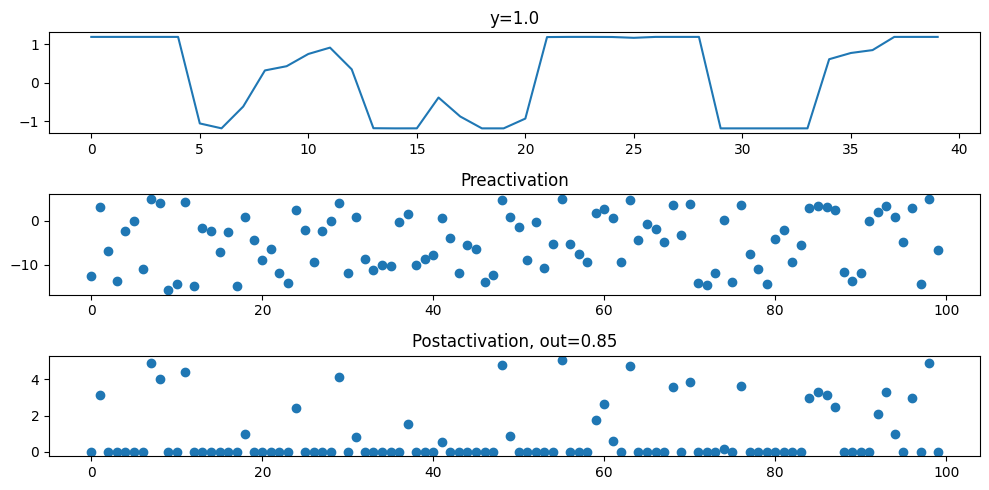

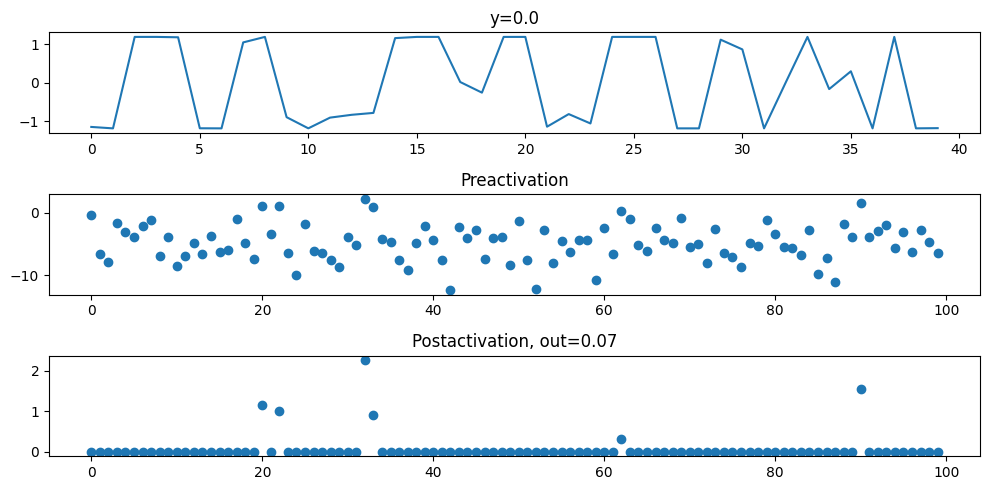

In [229]:
for i in [3, 4]:
    fig, axs = viz_activations(x[i], weights2_, bias2_, jax.nn.relu)
    axs[0].set_title(f"y={y[i]}")
    fig.tight_layout()

#### y = 0 corresponds to longer-scale correlation

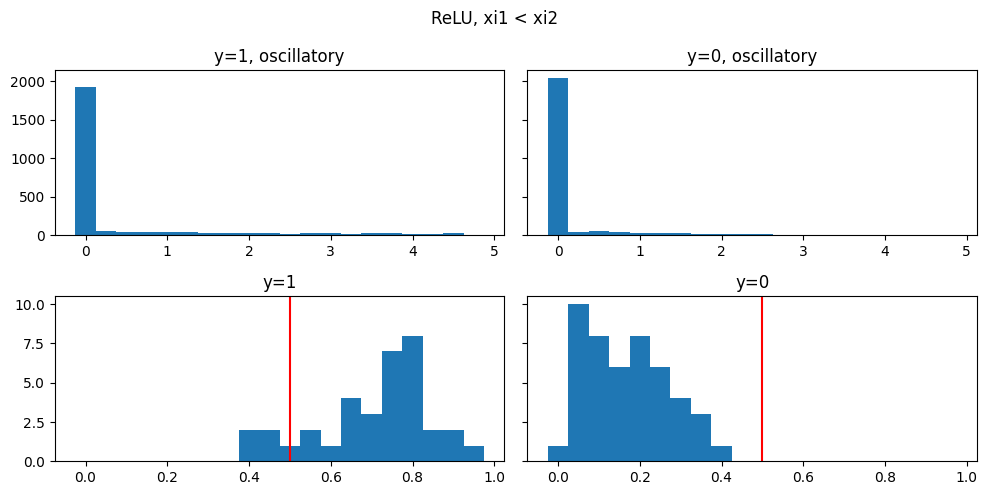

In [231]:
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), xi1=1, xi2=2, gain=3, num_dimensions=40)
x, y = dataset[:100]

preact3 = weights3_ @ x.T + bias3_.reshape(-1, 1)
postact3 = jax.nn.relu(preact3)
out3 = postact3.mean(axis=0)
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='row', sharey='row')
for col, ylabel in enumerate([1, 0]):
    data = postact3[neuron_mask,:][:,y == ylabel].flatten()
    counts, bins = np.histogram(data, range=(0, 5), bins=20)
    axs[0, col].bar(bins[:-1], counts, width=0.25)
    axs[0, col].set_title(f'y={ylabel}, oscillatory')
counts, bins = np.histogram(out3[y == 1], range=(0, 1), bins=20)
axs[1, 0].bar(bins[:-1], counts, width=0.05)
axs[1, 0].set_title('y=1')
axs[1, 0].axvline(0.5, color='red')
counts, bins = np.histogram(out3[y == 0], range=(0, 1), bins=20)
axs[1, 1].bar(bins[:-1], counts, width=0.05)
axs[1, 1].set_title('y=0')
axs[1, 1].axvline(0.5, color='red')
fig.suptitle('ReLU, xi1 < xi2')
fig.tight_layout()

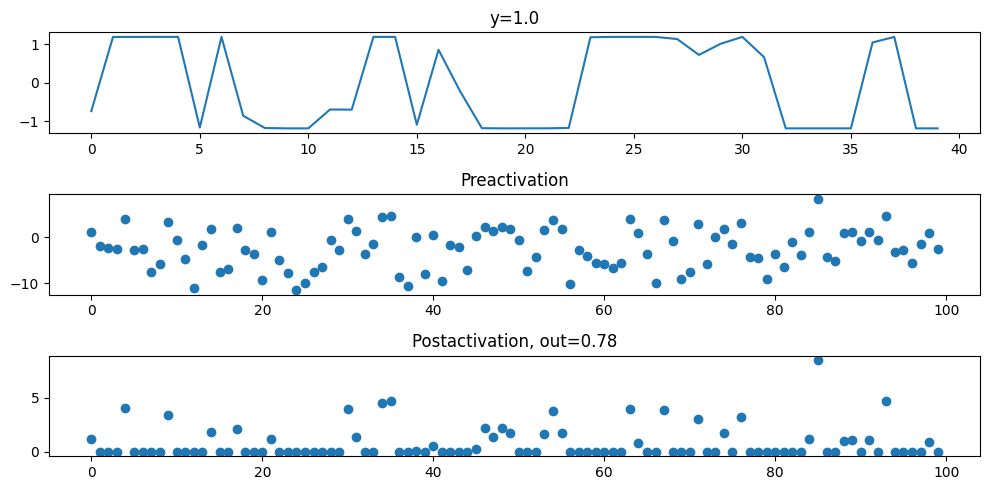

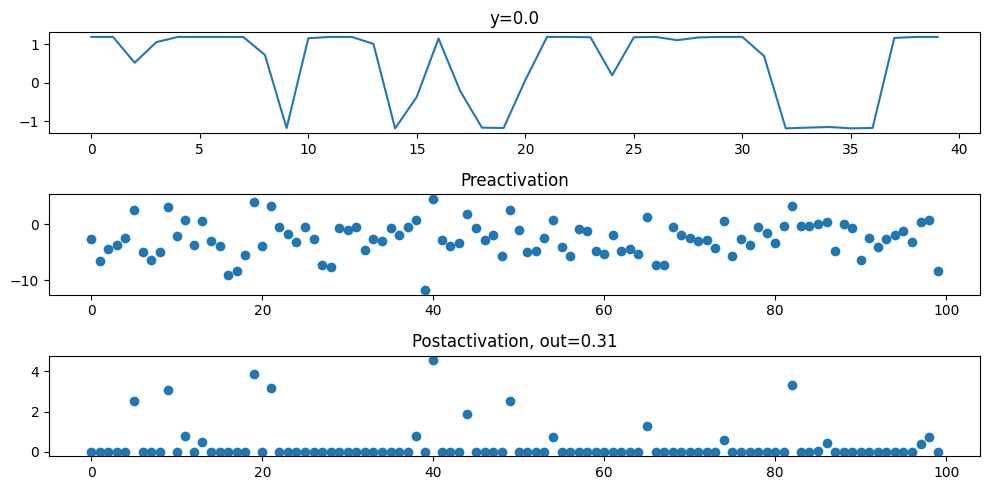

In [232]:
for i in [3, 4]:
    fig, axs = viz_activations(x[i], weights3_, bias3_, jax.nn.relu)
    axs[0].set_title(f"y={y[i]}")
    fig.tight_layout()

#### Getting rid of the bias term

Below, we show that for the NLGP dataset, we need the bias term if we use sigmoid activation.
We **do not need it** if we use ReLU activation.

The results do not depend on whether the support is (-1, 1) or (0, 1).

Already simulated


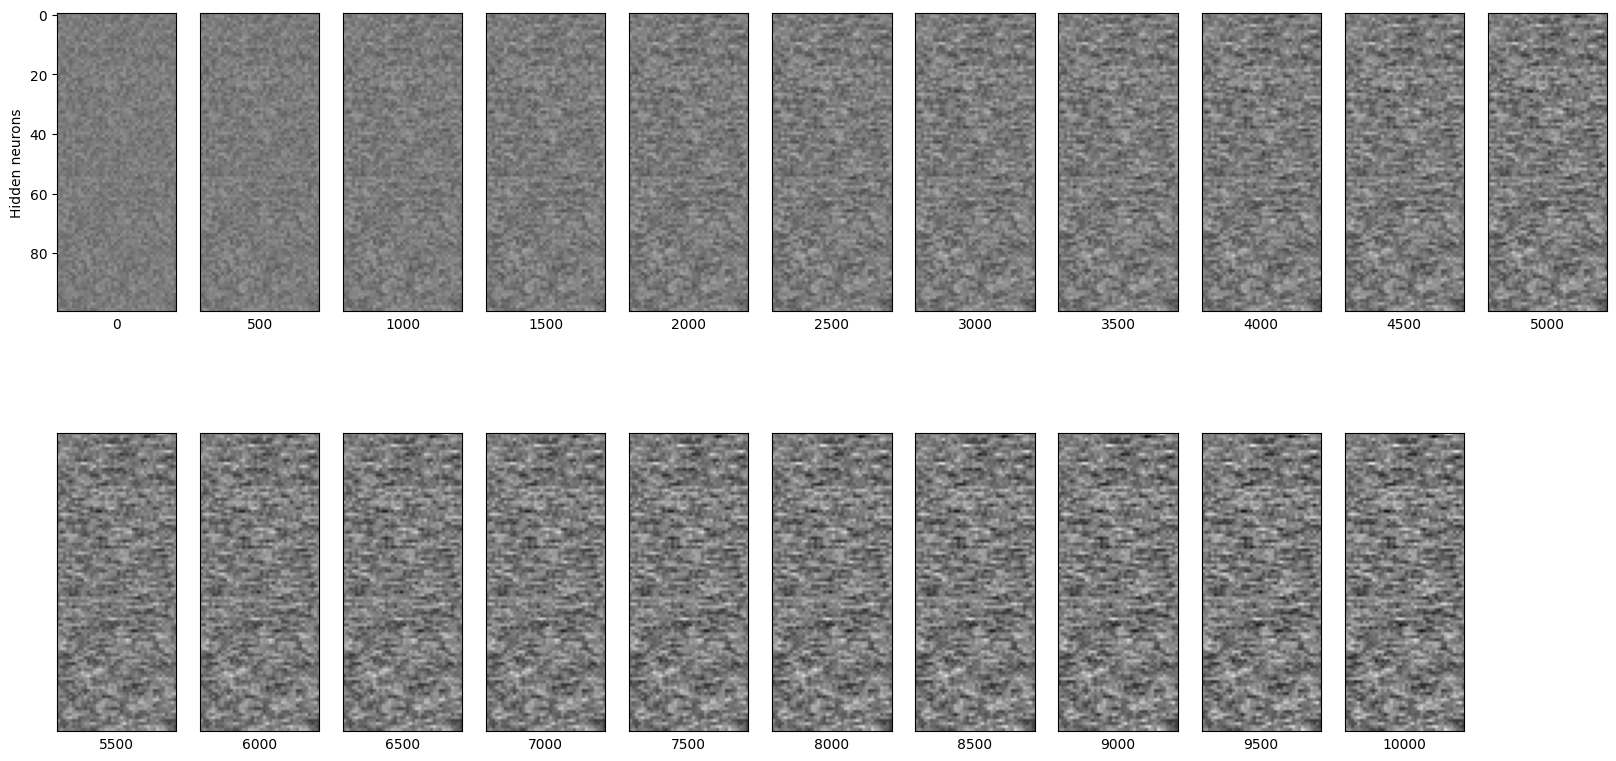

In [39]:
config = config_.copy()
config['xi1'] = 2
config['xi2'] = 1
config['gain'] = 3
config['learning_rate'] = 100
config['num_epochs'] = 10000
config['activation'] = 'sigmoid'
config['use_bias'] = False

# not shown here, but look into metrics to see that the model does not exceed null accuracy/loss
weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


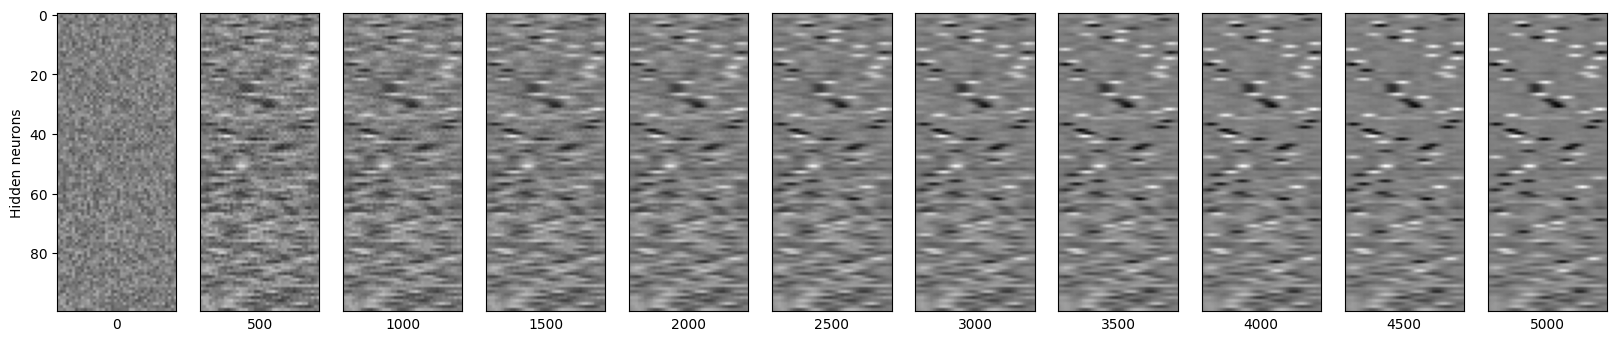

In [40]:
config = config_.copy()
config['xi1'] = 2
config['xi2'] = 1
config['gain'] = 3
config['learning_rate'] = 10
config['num_epochs'] = 1000
config['activation'] = 'relu'
config['use_bias'] = False

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

## SP dataset

First, we'll quickly show that if our pulses are distributed symmetrically on $[-1,1]^n$, then we get qualitatively similar results as above.
Namely, that with sigmoid activation we get both localized and oscillatory receptive fields, but with ReLU we only get one at a time.

Interestingly, we can get qualitatively similar results without the bias term when we train on this dataset, even with sigmoid activation.

In [2]:
config_ = dict(
  seed=0,
  num_dimensions=40,
  num_hiddens=100,
  init_scale=1.0,
  model_cls=models.SimpleNet,
  optimizer_fn=optax.sgd,
  batch_size=1000,
  dataset_cls=datasets.SinglePulseDataset,
  class_proportion=0.5,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  save_=True,
)

Already simulated


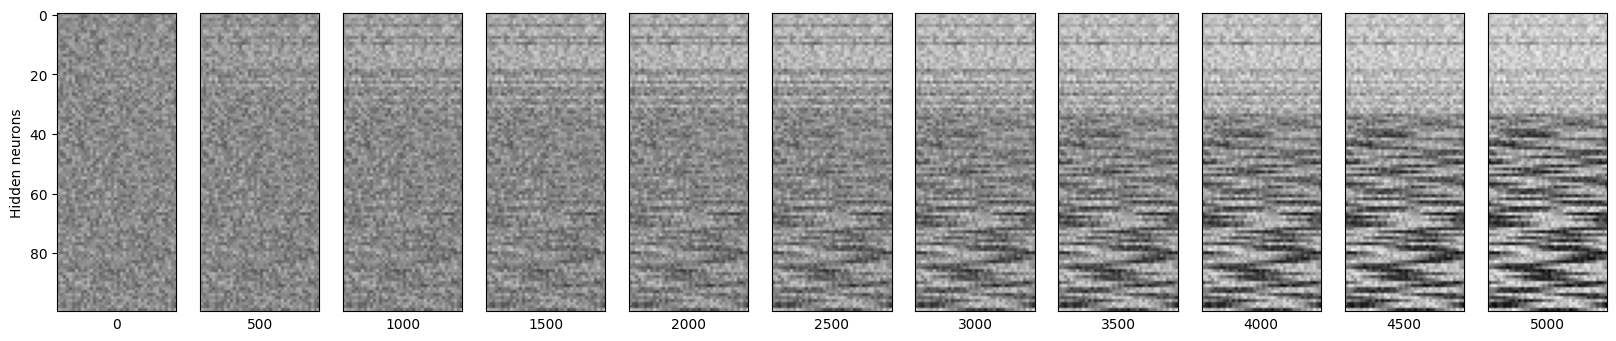

In [8]:
config = config_.copy()
config['xi1'] = (0.2, 0.25)
config['xi2'] = (0.05, 0.1)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 5000
config['activation'] = 'sigmoid'
config['use_bias'] = True
config['support'] = (-1, 1)

weights4, metrics4 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights4, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


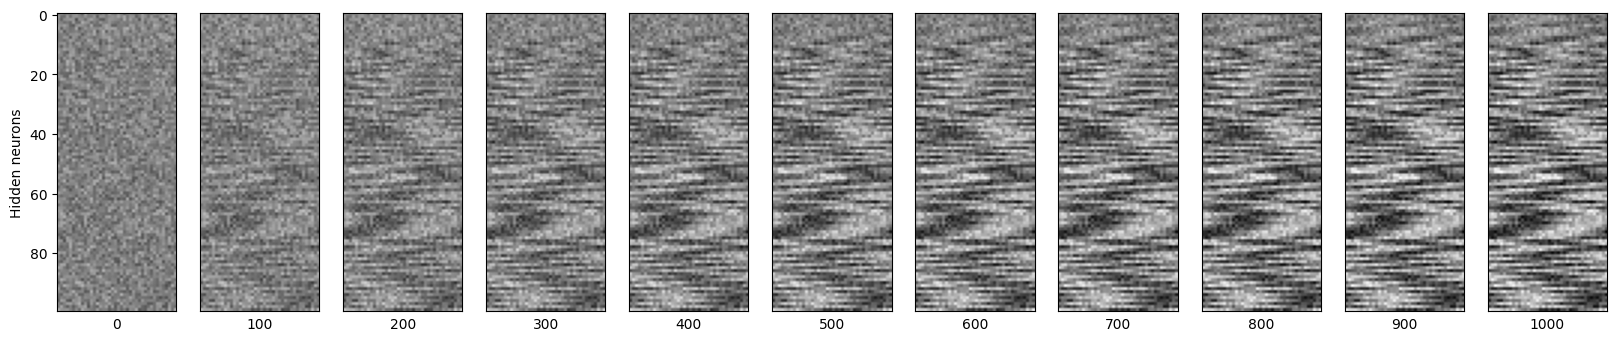

In [9]:
config = config_.copy()
config['xi1'] = (0.2, 0.25)
config['xi2'] = (0.05, 0.1)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 1000
config['activation'] = 'relu'
config['use_bias'] = True
config['support'] = (-1, 1)

weights5, metrics5 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights5, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


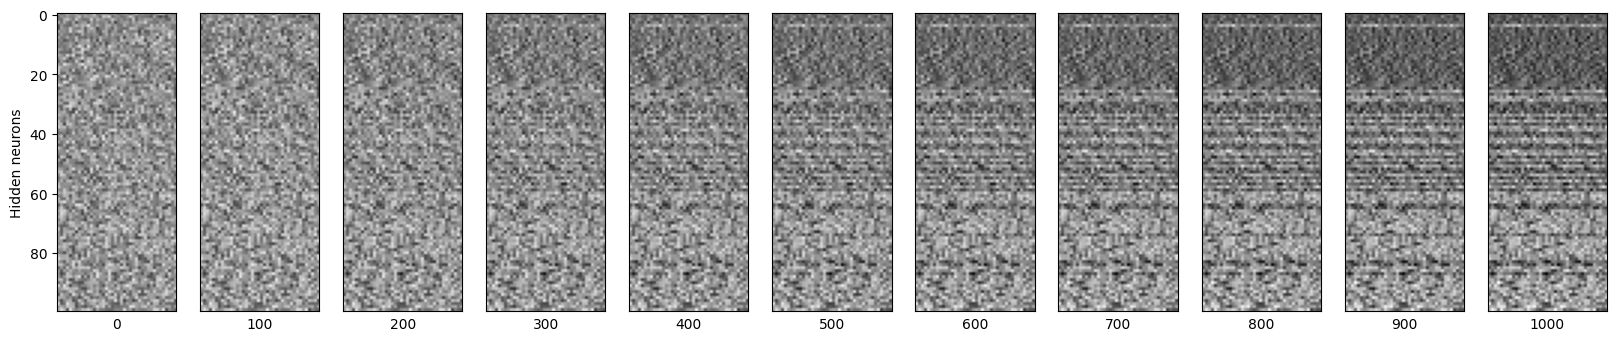

In [11]:
config = config_.copy()
config['xi1'] = (0.05, 0.1)
config['xi2'] = (0.2, 0.25)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 1000
config['activation'] = 'relu'
config['use_bias'] = True
config['support'] = (-1, 1)

weights6, metrics6 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights6, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

##### Getting rid of the bias term

Already simulated


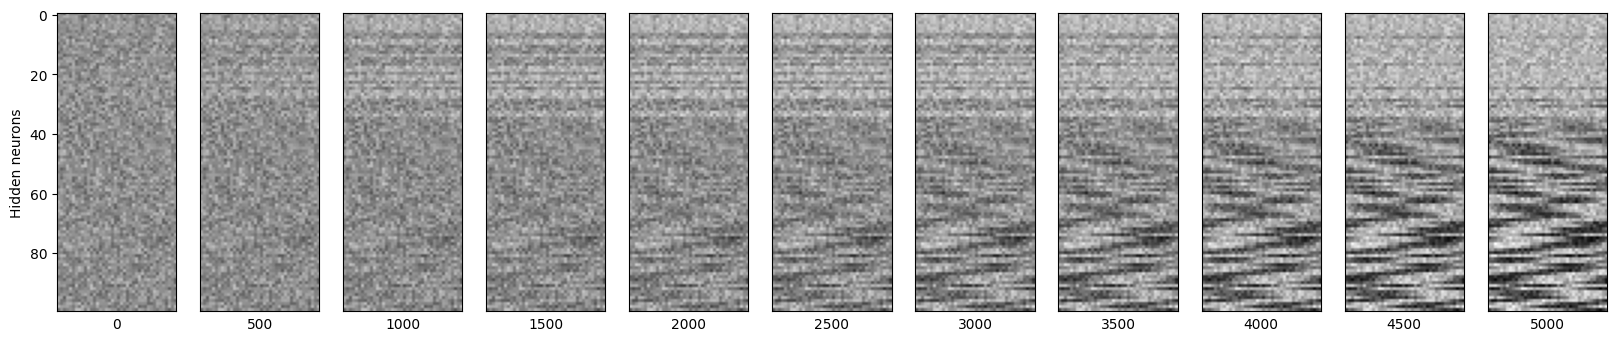

In [13]:
config = config_.copy()
config['xi1'] = (0.2, 0.25)
config['xi2'] = (0.05, 0.1)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 5000
config['activation'] = 'sigmoid'
config['use_bias'] = False
config['support'] = (-1, 1)

weights7, metrics7 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights7, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

kwargs: {}


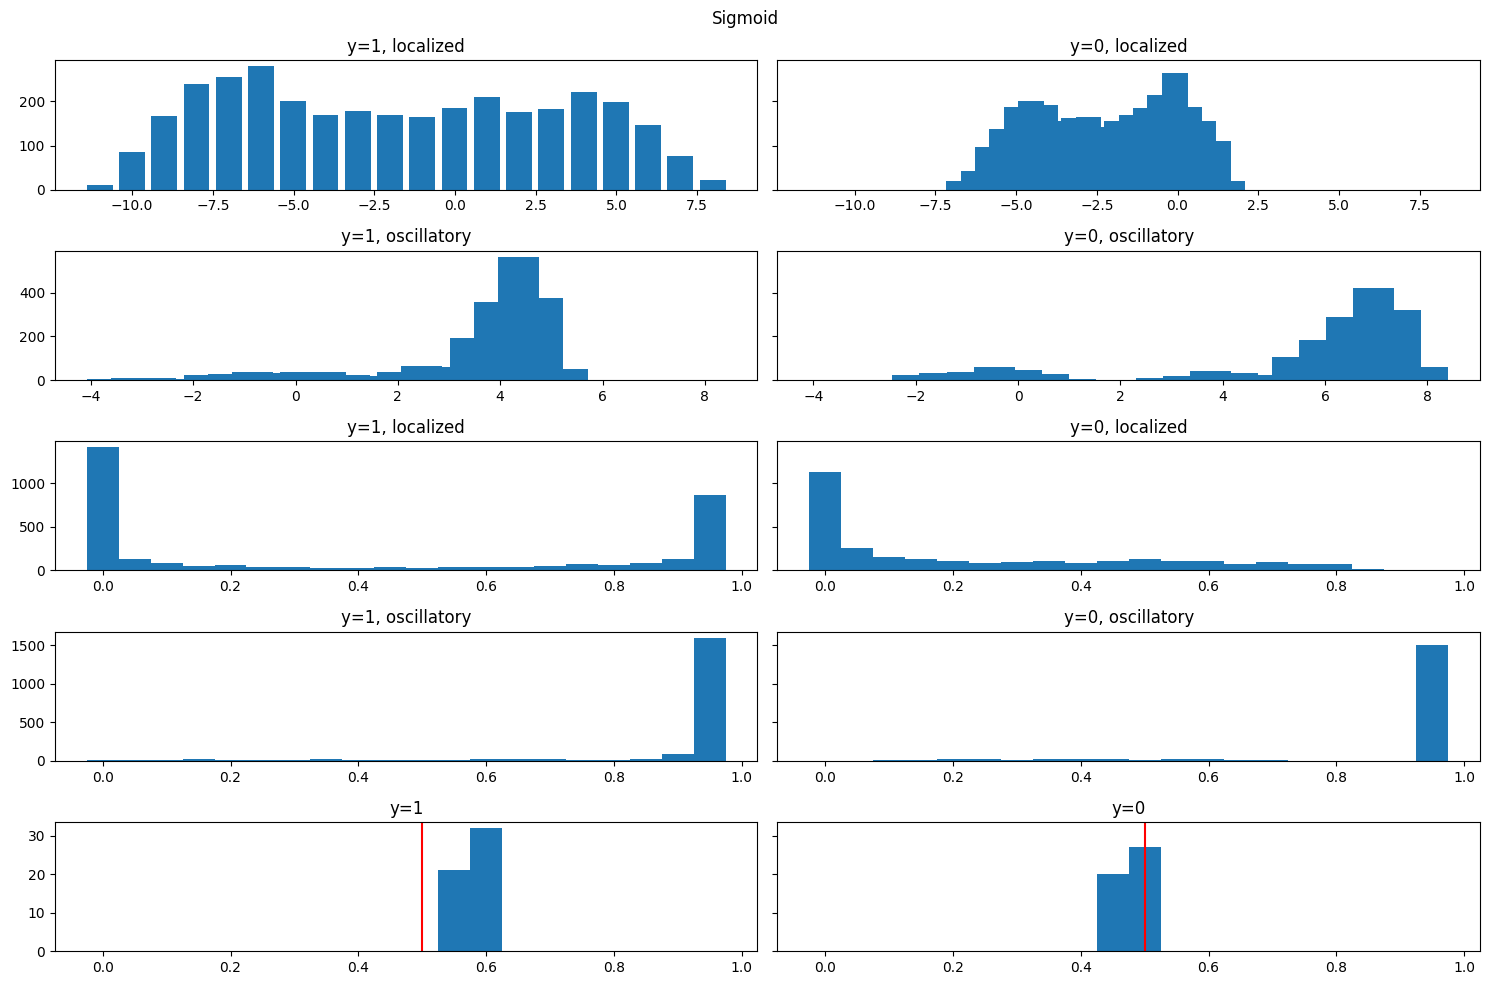

In [37]:
dataset = datasets.SinglePulseDataset(key=jax.random.PRNGKey(0), xi1=(0.2, 0.25), xi2=(0.05, 0.1), support=(-1, 1), num_dimensions=40)
x, y = dataset[:100]

localized7 = entropy(weights7[-1]) > 2.6
weights7_ = weights7[-1]
preact7 = weights7_ @ x.T
postact7 = jax.nn.sigmoid(preact7)
out7 = postact7.mean(axis=0)
fig, axs = plt.subplots(5, 2, figsize=(15, 10), sharex='row', sharey='row')
for row, neuron_mask in enumerate([localized7, ~localized7]):
    for col, ylabel in enumerate([1, 0]):
        # preactivations
        data = preact7[neuron_mask,:][:,y == ylabel].flatten()
        counts, bins = np.histogram(data, bins=20) # , range=(0, 1)
        axs[row, col].bar(bins[:-1], counts)
        axs[row, col].set_title(f'y={ylabel}, {"localized" if row == 0 else "oscillatory"}')
        # postactivations
        data = postact7[neuron_mask,:][:,y == ylabel].flatten()
        counts, bins = np.histogram(data, range=(0, 1), bins=20)
        axs[row+2, col].bar(bins[:-1], counts, width=0.05)
        axs[row+2, col].set_title(f'y={ylabel}, {"localized" if row == 0 else "oscillatory"}')
    # axs[row, 0].set_ylabel('preactivations')
    # axs[row+2, 0].set_ylabel('postactivations')
counts, bins = np.histogram(out7[y == 1], range=(0, 1), bins=20)
axs[4, 0].bar(bins[:-1], counts, width=0.05)
axs[4, 0].set_title('y=1')
axs[4, 0].axvline(0.5, color='red')
counts, bins = np.histogram(out7[y == 0], range=(0, 1), bins=20)
axs[4, 1].bar(bins[:-1], counts, width=0.05)
axs[4, 1].set_title('y=0')
axs[4, 1].axvline(0.5, color='red')
fig.suptitle('Sigmoid')
fig.tight_layout()

Already simulated


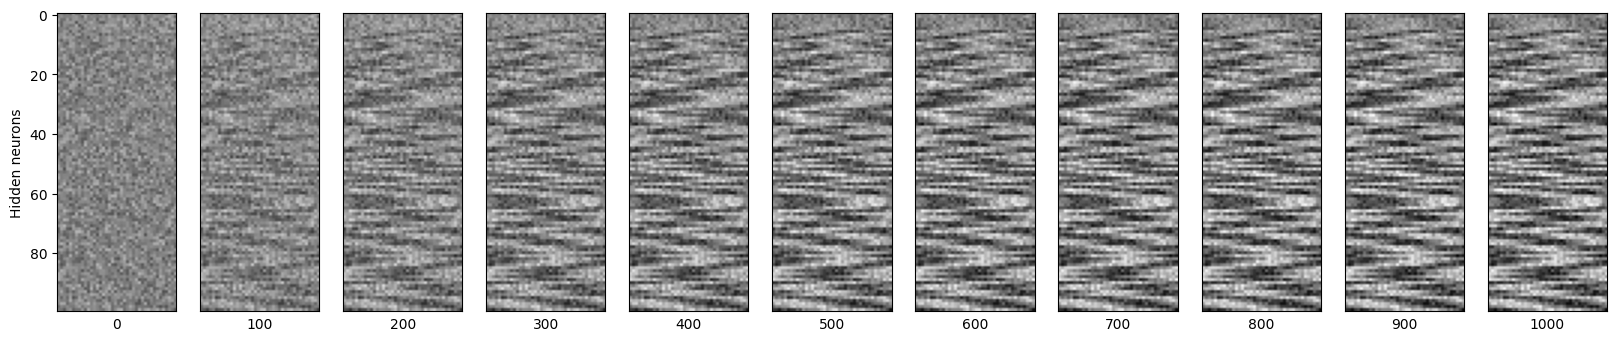

In [18]:
config = config_.copy()
config['xi1'] = (0.2, 0.25)
config['xi2'] = (0.05, 0.1)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 1000
config['activation'] = 'relu'
config['use_bias'] = False
config['support'] = (-1, 1)

weights8, metrics8 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights8, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


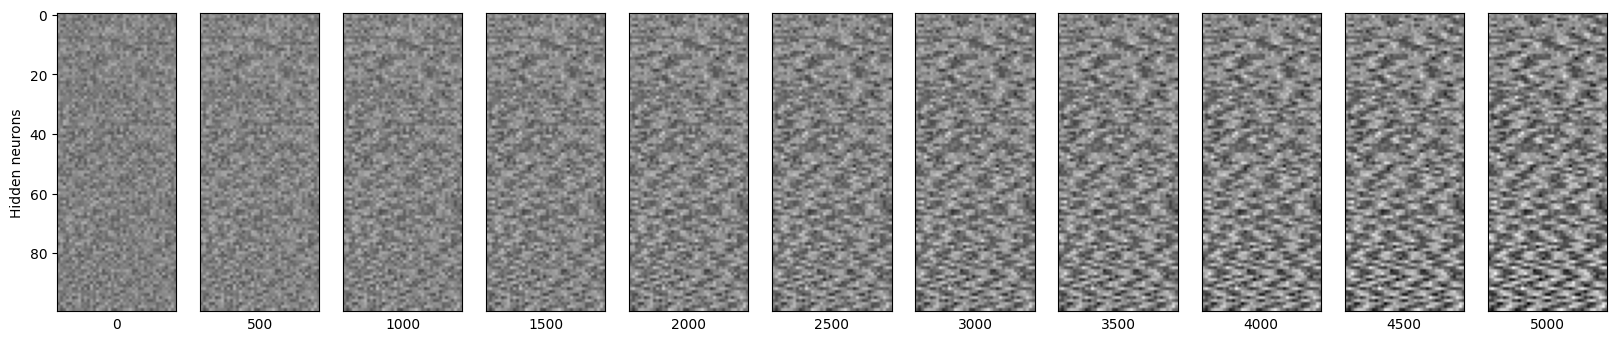

In [20]:
config = config_.copy()
config['xi1'] = (0.05, 0.1)
config['xi2'] = (0.2, 0.25)
config['learning_rate'] = 2.0 # 10.0
config['num_epochs'] = 1000
config['activation'] = 'relu'
config['use_bias'] = False
config['support'] = (-1, 1)

weights9, metrics9 = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights9, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

## Other cases

There are many settings not shown here.
Importantly, what if we have fewer hidden neurons than input neurons?

Some other settings I explored I will quickly summarize here:
- What if we make the class labels 1 and 2 with a ReLU network, instead of 0 and 1?
It does not learn.
Why?
Because the receptive fields work by playing with variances of preactivations.
They need to be able to be able to arbitrarily increase preactivations in some direction without incurring greater loss for at least one of the labels.
This is not the case if we use ReLU with labels 1 and 2, but it is the case if we use 0 and 1.
- Moving from (-1,1) to (0,1) support never seems to qualitatively change the results, even with/without learnable bias terms. I don't fully understand this yet.

## Questions

- I still do not really understand why we can use sigmoid activation without a bias on the SP dataset, but not the NLGP dataset.
Perhaps the latter would work if I made the signals easier to discriminate?

## To-do's

- Run the above, but with settings so that we do not get redundant localized receptive fields with ReLU activation.
- Stare at the activations until a gating structure becomes clear.
- Maybe also see how the model performs when initialized with very small weights.